Used https://www.kaggle.com/praveenmaripeti/wids-datathon-2021-challenge-eda-model-submission as the starting notebook

# Problem Overview

This challenge is hosted by WiDS Datathon Committee. It focuses on patient health, with an emphasis on the chronic condition of diabetes, through data from MIT’s GOSSIS (Global Open Source Severity of Illness Score) initiative.

**Background**

Getting a rapid understanding of the context of a patient’s overall health has been particularly important during the COVID-19 pandemic as healthcare workers around the world struggle with hospitals overloaded by patients in critical condition. Intensive Care Units (ICUs) often lack verified medical histories for incoming patients. A patient in distress or a patient who is brought in confused or unresponsive may not be able to provide information about chronic conditions such as heart disease, injuries, or diabetes. Medical records may take days to transfer, especially for a patient from another medical provider or system. Knowledge about chronic conditions such as diabetes can inform clinical decisions about patient care and ultimately improve patient outcomes.

**Overview**

In this challenge, participants are required to build a model to determine whether a patient admitted to an ICU has been diagnosed with a particular type of diabetes, Diabetes Mellitus.

# Import Libraries

In [1]:
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt  #data visualization
import seaborn as sns
import plotly.graph_objects as go
import missingno as msno

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV

from sklearn.experimental import enable_iterative_imputer   # For imputing missing values
from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer

from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix  #metrics
from scipy import stats

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier # Needs libxgboost.dylib : brew install libomp

import warnings
warnings.filterwarnings('ignore')  #silence warnings

### CONSTANTS

In [2]:
DATA_FOLDER = "data" #"../input/widsdatathon2021"

CAT_COLUMNS = {
    "demographic1" : ['age', 'gender', 'ethnicity', 'weight', 'height', 'bmi'], 
    "demographic2" : ['elective_surgery', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type','icu_type',           
    'pre_icu_los_days'], 
    "apache_covariate" : ['albumin_apache', 'apache_2_diagnosis', 'apache_3j_diagnosis',
       'apache_post_operative', 'arf_apache', 'bilirubin_apache', 'bun_apache',
       'creatinine_apache', 'fio2_apache', 'gcs_eyes_apache',
       'gcs_motor_apache', 'gcs_unable_apache', 'gcs_verbal_apache',
       'glucose_apache', 'heart_rate_apache', 'hematocrit_apache',
       'intubated_apache', 'map_apache', 'paco2_apache', 'paco2_for_ph_apache',
       'pao2_apache', 'ph_apache', 'resprate_apache', 'sodium_apache',
       'temp_apache', 'urineoutput_apache', 'ventilated_apache', 'wbc_apache'],
    "apache_comorbidity" : ['aids', 'cirrhosis', 'hepatic_failure', 'immunosuppression', 'leukemia',
       'lymphoma', 'solid_tumor_with_metastasis'],
    "vitals_d1" : ['d1_diasbp_invasive_max', 'd1_diasbp_invasive_min', 'd1_diasbp_max',
       'd1_diasbp_min', 'd1_diasbp_noninvasive_max',
       'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min',
       'd1_mbp_invasive_max', 'd1_mbp_invasive_min', 'd1_mbp_max',
       'd1_mbp_min', 'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min',
       'd1_resprate_max', 'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min',
       'd1_sysbp_invasive_max', 'd1_sysbp_invasive_min', 'd1_sysbp_max',
       'd1_sysbp_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min',
       'd1_temp_max', 'd1_temp_min'],
    "vitals_h1" : ['h1_diasbp_invasive_max', 'h1_diasbp_invasive_min', 'h1_diasbp_max',
       'h1_diasbp_min', 'h1_diasbp_noninvasive_max',
       'h1_diasbp_noninvasive_min', 'h1_heartrate_max', 'h1_heartrate_min',
       'h1_mbp_invasive_max', 'h1_mbp_invasive_min', 'h1_mbp_max',
       'h1_mbp_min', 'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min',
       'h1_resprate_max', 'h1_resprate_min', 'h1_spo2_max', 'h1_spo2_min',
       'h1_sysbp_invasive_max', 'h1_sysbp_invasive_min', 'h1_sysbp_max',
       'h1_sysbp_min', 'h1_sysbp_noninvasive_max', 'h1_sysbp_noninvasive_min',
       'h1_temp_max', 'h1_temp_min'],
    "labs_d1" :['d1_albumin_max', 'd1_albumin_min', 'd1_bilirubin_max',
       'd1_bilirubin_min', 'd1_bun_max', 'd1_bun_min', 'd1_calcium_max',
       'd1_calcium_min', 'd1_creatinine_max', 'd1_creatinine_min',
       'd1_glucose_max', 'd1_glucose_min', 'd1_hco3_max', 'd1_hco3_min',
       'd1_hemaglobin_max', 'd1_hemaglobin_min', 'd1_hematocrit_max',
       'd1_hematocrit_min', 'd1_inr_max', 'd1_inr_min', 'd1_lactate_max',
       'd1_lactate_min', 'd1_platelets_max', 'd1_platelets_min',
       'd1_potassium_max', 'd1_potassium_min', 'd1_sodium_max',
       'd1_sodium_min', 'd1_wbc_max', 'd1_wbc_min'],
    "labs_h1" : ['h1_albumin_max', 'h1_albumin_min', 'h1_bilirubin_max',
       'h1_bilirubin_min', 'h1_bun_max', 'h1_bun_min', 'h1_calcium_max',
       'h1_calcium_min', 'h1_creatinine_max', 'h1_creatinine_min',
       'h1_glucose_max', 'h1_glucose_min', 'h1_hco3_max', 'h1_hco3_min',
       'h1_hemaglobin_max', 'h1_hemaglobin_min', 'h1_hematocrit_max',
       'h1_hematocrit_min', 'h1_inr_max', 'h1_inr_min', 'h1_lactate_max',
       'h1_lactate_min', 'h1_platelets_max', 'h1_platelets_min',
       'h1_potassium_max', 'h1_potassium_min', 'h1_sodium_max',
       'h1_sodium_min', 'h1_wbc_max', 'h1_wbc_min'], 
    "labs_blood_gas" : ['d1_arterial_pco2_max',
       'd1_arterial_pco2_min', 'd1_arterial_ph_max', 'd1_arterial_ph_min',
       'd1_arterial_po2_max', 'd1_arterial_po2_min', 'd1_pao2fio2ratio_max',
       'd1_pao2fio2ratio_min', 'h1_arterial_pco2_max', 'h1_arterial_pco2_min',
       'h1_arterial_ph_max', 'h1_arterial_ph_min', 'h1_arterial_po2_max',
       'h1_arterial_po2_min', 'h1_pao2fio2ratio_max', 'h1_pao2fio2ratio_min']
}

DEFAULT_COLOR = '#812878'

CAT_COLORS = {  'demographic1':  '#812878',                             
                'demographic2':  '#B0B3D6',
                'apache_covariate': '#2C2255',
                'apache_comorbidity': '#4B8BBE',
                'vitals_d1':  '#CC2336', 
                'vitals_h1': '#FFE873',
                'labs_d1': '#E4682A', 
                'labs_h1': '#FFD43B', 
                'labs_blood_gas': '#F69824'
                }

### COMMON FUNCTIONS

In [3]:
def getColor(col):
    for cat in CAT_COLUMNS.keys():
        if col in CAT_COLUMNS[cat]: 
            return CAT_COLORS.get(cat, '#333333')
        else:
            return '#333333'

# PRINTS MISSING DATA INFORMATION
def missingData(df):
    print(df.shape)
    missing_cnt = df.isna().sum() #column wise sum of missing values
    if missing_cnt.sum() == 0:
        print("There are no missing values")
        return pd.DataFrame()

    #display only the columns with missing values with count and proportion of missing values by column 
    missing_df = pd.concat([missing_cnt.rename('Missing Count'), 
                            missing_cnt.div(len(df)/100).rename('Missing Ratio')], axis=1).loc[missing_cnt.ne(0)]
    missing_df = missing_df.reset_index().rename(columns={'index': 'Feature'})
    missing_df['Filled Ratio'] = missing_df['Missing Ratio'].apply(lambda x: 100-x)
    print(missing_df)
    COLORS=[getColor(col) for col in missing_df['Feature'].values]
    print(missing_df.columns)
    #print(COLORS)
    missing_df.plot.bar(x='Feature', y='Filled Ratio', title="Filled data", figsize=(18,6), fontsize=7, color=COLORS)
    return missing_df

# PRINT DATAFRAME DETAILS IN A COMPACT FORM
DF_LOGS = pd.DataFrame(columns = ["name", "rows", "columns", "null" , "null%", "columns-all", "columns-cat"])
DF_LOGS[['null%']] = DF_LOGS[['null%']].applymap("{0:.2f}".format)
def printDFDetails(dfname, df):
    global DF_LOGS
    log = f"{dfname}: Shape: {df.shape}; Null values: {pd.DataFrame(df).isna().sum().sum()}, {(df.isnull().any(axis=1).sum()/df.shape[0])*100:0.2f}%\nColumns: {df.columns} \nColumns of object type: {df.select_dtypes('object').columns}"
    print(log)
    DF_LOGS = DF_LOGS.append( { "name": dfname, "rows": df.shape[0], "columns": df.shape[1], "null" : df.isnull().sum().sum(), "null%": (df.isnull().any(axis=1).sum()/df.shape[0])*100, 
                "columns-all": df.columns.values, "columns-cat": df.select_dtypes('object').columns.values}, ignore_index=True)
    #print(f"{dfname}:{log}")

# PRINT DATAFRAME DETAILED BY GROUPING ON THE COLS    
def printDFGroups(df, cols):
    for col in cols:
        print(df.groupby(by=col)[col].agg(['count']))

# PRINT NAN ROW INFORMATION
def nanRows(df):
    return f"{df.isnull().any(axis=1).sum()}, {(df.isnull().any(axis=1).sum()/df.shape[0])*100:0.2f}%"

'''
Computes roc auc score as the score will computed for several datasets. 
- It will split the training set into a sub training set (80%) and test set(20%). 
- A simple XGBClassifier will be trained on the sub training set, evaluated on test set.
- Finally the function prints roc auc score on full training set and the original test set.
'''
def compute_roc_auc(xgb, train_set, target):
    tic = datetime.now()
    X_train, X_test, y_train, y_test = train_test_split(train_set, target, test_size=0.2, random_state=42)
    xgb.fit(X_train, y_train)
    y_test_pred = xgb.predict(X_test)
    y_train_pred = xgb.predict(X_train)
    print('train auc',roc_auc_score(y_train, y_train_pred))
    print('test auc',roc_auc_score(y_test, y_test_pred)) 
    toc = datetime.now()
    print("Time taken:", toc-tic)  
    return xgb

# PRINTS THE FEATURE IMPORTANCE
def getFeatureImportance(xgb, df, all=False):
    count = 0
    col_imp = {}
    for col in df.columns.values:
        #print(col, xgb.feature_importances_[count])
        col_imp[col] = xgb.feature_importances_[count]
        count += 1

    col_imp_sorted = {k: v for k, v in sorted(col_imp.items(), key=lambda item: item[1])}

    count = 0; MAX = 25
    for w in sorted(col_imp_sorted, key=col_imp_sorted.get, reverse=True):
        print(w, col_imp_sorted[w])
        count += 1
        if all == False and count == MAX:
            break


# Load data

In [4]:
df = pd.read_csv(f"{DATA_FOLDER}/TrainingWiDS2021.csv")
df_unlabeled = pd.read_csv(f"{DATA_FOLDER}/UnlabeledWiDS2021.csv")
ddic = pd.read_csv(f"{DATA_FOLDER}/DataDictionaryWiDS2021.csv")

In [5]:
labs=ddic.index[(ddic['Category']=='labs')]
df.iloc[:,labs-1].columns

Index(['h1_temp_min', 'd1_albumin_max', 'd1_albumin_min', 'd1_bilirubin_max',
       'd1_bilirubin_min', 'd1_bun_max', 'd1_bun_min', 'd1_calcium_max',
       'd1_calcium_min', 'd1_creatinine_max', 'd1_creatinine_min',
       'd1_glucose_max', 'd1_glucose_min', 'd1_hco3_max', 'd1_hco3_min',
       'd1_hemaglobin_max', 'd1_hemaglobin_min', 'd1_hematocrit_max',
       'd1_hematocrit_min', 'd1_inr_max', 'd1_inr_min', 'd1_lactate_max',
       'd1_lactate_min', 'd1_platelets_max', 'd1_platelets_min',
       'd1_potassium_max', 'd1_potassium_min', 'd1_sodium_max',
       'd1_sodium_min', 'd1_wbc_max', 'd1_wbc_min', 'h1_albumin_max',
       'h1_albumin_min', 'h1_bilirubin_max', 'h1_bilirubin_min', 'h1_bun_max',
       'h1_bun_min', 'h1_calcium_max', 'h1_calcium_min', 'h1_creatinine_max',
       'h1_creatinine_min', 'h1_glucose_max', 'h1_glucose_min', 'h1_hco3_max',
       'h1_hco3_min', 'h1_hemaglobin_max', 'h1_hemaglobin_min',
       'h1_hematocrit_max', 'h1_hematocrit_min', 'h1_inr_max', 'h1

# Exploratory Data Analysis

In [6]:
df.head()

,Unnamed: 0,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,...,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
0,1,214826,118,68.0,22.732803,0,Caucasian,M,180.3,Floor,...,NaN,NaN,0,0,0,0,0,0,0,1
1,2,246060,81,77.0,27.421875,0,Caucasian,F,160.0,Floor,...,51.0,51.0,0,0,0,0,0,0,0,1
2,3,276985,118,25.0,31.952749,0,Caucasian,F,172.7,Emergency Department,...,NaN,NaN,0,0,0,0,0,0,0,0
3,4,262220,118,81.0,22.635548,1,Caucasian,F,165.1,Operating Room,...,337.0,337.0,0,0,0,0,0,0,0,0
4,5,201746,33,19.0,NaN,0,Caucasian,M,188.0,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0


In [7]:
df_unlabeled.head()

,Unnamed: 0,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,...,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
0,1,144740,10141,72,NaN,0,Caucasian,F,152.4,Floor,...,NaN,NaN,NaN,0,0,0,0,0,0,0
1,2,141990,10141,86,NaN,0,Caucasian,F,175.3,Emergency Department,...,NaN,NaN,NaN,0,0,0,0,0,0,0
2,3,142038,10141,72,NaN,0,Caucasian,F,162.6,Floor,...,NaN,NaN,NaN,0,0,0,0,0,0,0
3,4,138628,10141,66,NaN,0,Caucasian,M,177.8,Floor,...,NaN,NaN,NaN,0,0,0,0,0,0,0
4,5,141682,10141,89,NaN,0,Caucasian,M,170.2,Direct Admit,...,NaN,NaN,NaN,0,0,0,0,0,0,0


In [8]:
print(df.shape)
print(df_unlabeled.shape)

(130157, 181)
(10234, 180)


In [9]:
df.describe() # summary statistics for numeric features

,Unnamed: 0,encounter_id,hospital_id,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,readmission_status,...,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
count,130157.000000,130157.000000,130157.000000,125169.000000,125667.000000,130157.000000,128080.000000,130157.000000,130157.000000,130157.0,...,16760.000000,16760.000000,130157.00000,130157.000000,130157.000000,130157.000000,130157.000000,130157.000000,130157.000000,130157.000000
mean,65079.000000,213000.856519,106.102131,61.995103,29.110260,0.189840,169.607219,662.428344,0.839933,0.0,...,247.525419,239.617358,0.00103,0.016081,0.013599,0.025669,0.007307,0.004187,0.020852,0.216285
std,37573.233831,38109.828146,63.482277,16.822880,8.262776,0.392176,10.833085,304.259843,2.485337,0.0,...,131.440167,128.562211,0.03207,0.125786,0.115819,0.158146,0.085166,0.064574,0.142888,0.411712
min,1.000000,147000.000000,1.000000,0.000000,14.844926,0.000000,137.200000,82.000000,-0.250000,0.0,...,42.000000,38.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32540.000000,180001.000000,49.000000,52.000000,23.598006,0.000000,162.500000,427.000000,0.045833,0.0,...,144.000000,138.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,65079.000000,213014.000000,112.000000,64.000000,27.564749,0.000000,170.100000,653.000000,0.155556,0.0,...,228.125000,218.750000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,97618.000000,246002.000000,165.000000,75.000000,32.803127,0.000000,177.800000,969.000000,0.423611,0.0,...,333.000000,324.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,130157.000000,279000.000000,204.000000,89.000000,67.814990,1.000000,195.590000,1111.000000,175.627778,0.0,...,720.000000,654.813793,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Drop columns with all unique values or same value

In [10]:
df.drop(['Unnamed: 0'], axis=1, inplace=True) #drop columns with all unique values # , 'encounter_id', 'hospital_id', 'icu_id', 'readmission_status'

#test_ids = df_unlabeled.pop('encounter_id')  # ids required for submission
unlabeled_ids = df_unlabeled['encounter_id']
df_unlabeled.drop(['Unnamed: 0'], axis=1, inplace=True) 

target = df['diabetes_mellitus']
print(df.shape)
print(df_unlabeled.shape)
print(type(unlabeled_ids))

(130157, 180)
(10234, 179)
<class 'pandas.core.series.Series'>


### Remove rows where all glucose values are null
Removal of rows brought the AUC scores down
#### TODO: Drop rows with more than 80 to 90% missing data

In [11]:
GLUCOSE_COLUMNS = ['d1_glucose_max', 'd1_glucose_min', 'h1_glucose_max', 'h1_glucose_min']
VITALS_COLUMNS = CAT_COLUMNS["vitals_d1"] + CAT_COLUMNS["vitals_h1"]

def getRowsWithAllVarsNans(df, cols):
    n = df[GLUCOSE_COLUMNS].isnull().all(1).sum()
    print(f"{n}, {n/df.shape[0] * 100:0.2f}%")
    idx = df.index[df[GLUCOSE_COLUMNS].isnull().all(1)]
    print(type(idx), idx, idx.shape)
    df_mod = df.drop(idx)
    print(df_mod.shape, df.shape[0] - df_mod.shape[0])
    #nans = df.ix[idx]
    #print(type(nans), nans)
    return df_mod

#df = getRowsWithAllVarsNans(df, GLUCOSE_COLUMNS)
#df = getRowsWithAllVarsNans(df, VITALS_COLUMNS)
#target = df['diabetes_mellitus']

#df_unlabeled = getRowsWithAllVarsNans(df_unlabeled, GLUCOSE_COLUMNS)
#df_unlabeled = getRowsWithAllVarsNans(df_unlabeled, VITALS_COLUMNS)

# Missing values

The data size is quite large, it has 130157 X 181 values. Let's see how many columns have missing values in terms of percentage.

(130157, 180)
                  Feature  Missing Count  Missing Ratio  Filled Ratio
0                     age           4988       3.832295     96.167705
1                     bmi           4490       3.449680     96.550320
2               ethnicity           1587       1.219297     98.780703
3                  gender             66       0.050708     99.949292
4                  height           2077       1.595765     98.404235
..                    ...            ...            ...           ...
155    h1_arterial_ph_min         107849      82.860699     17.139301
156   h1_arterial_po2_max         107445      82.550305     17.449695
157   h1_arterial_po2_min         107445      82.550305     17.449695
158  h1_pao2fio2ratio_max         113397      87.123243     12.876757
159  h1_pao2fio2ratio_min         113397      87.123243     12.876757

[160 rows x 4 columns]
Index(['Feature', 'Missing Count', 'Missing Ratio', 'Filled Ratio'], dtype='object')


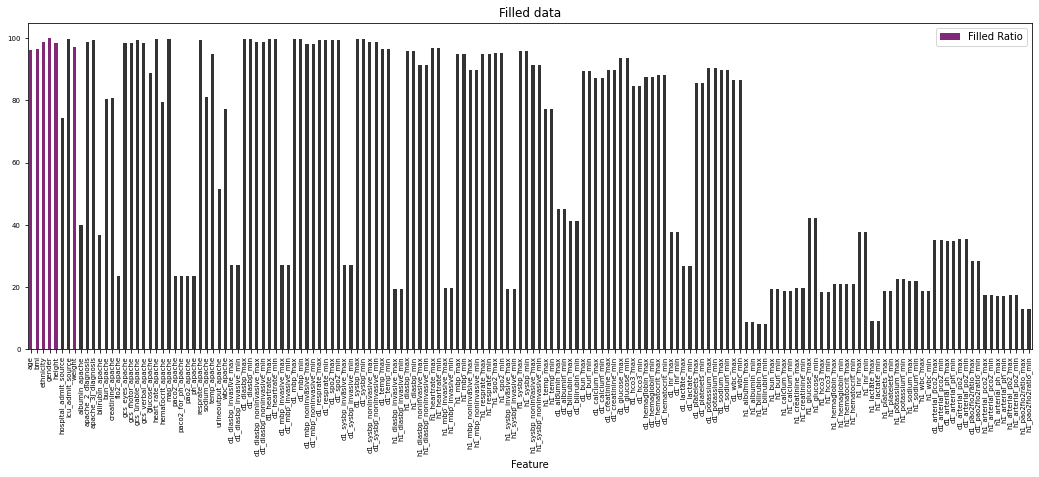

In [12]:
missing_df = missingData(df)

Out of 181 columns, 160 have missing values. The proportion of missing values in some columns is more than 80%. Clearly, missing values is a major issue with this data which needs to be fixed.

(10234, 179)
                   Feature  Missing Count  Missing Ratio  Filled Ratio
0                      bmi           1015       9.917921     90.082079
1                ethnicity            204       1.993355     98.006645
2                   gender              5       0.048857     99.951143
3                   height            301       2.941176     97.058824
4    hospital_admit_source           2733      26.705101     73.294899
..                     ...            ...            ...           ...
154     h1_arterial_ph_min           8401      82.089115     17.910885
155    h1_arterial_po2_max           8306      81.160836     18.839164
156    h1_arterial_po2_min           8306      81.160836     18.839164
157   h1_pao2fio2ratio_max           8812      86.105140     13.894860
158   h1_pao2fio2ratio_min           8812      86.105140     13.894860

[159 rows x 4 columns]
Index(['Feature', 'Missing Count', 'Missing Ratio', 'Filled Ratio'], dtype='object')


,Feature,Missing Count,Missing Ratio,Filled Ratio
0,bmi,1015,9.917921,90.082079
1,ethnicity,204,1.993355,98.006645
2,gender,5,0.048857,99.951143
3,height,301,2.941176,97.058824
4,hospital_admit_source,2733,26.705101,73.294899
...,...,...,...,...
154,h1_arterial_ph_min,8401,82.089115,17.910885
155,h1_arterial_po2_max,8306,81.160836,18.839164
156,h1_arterial_po2_min,8306,81.160836,18.839164
157,h1_pao2fio2ratio_max,8812,86.105140,13.894860


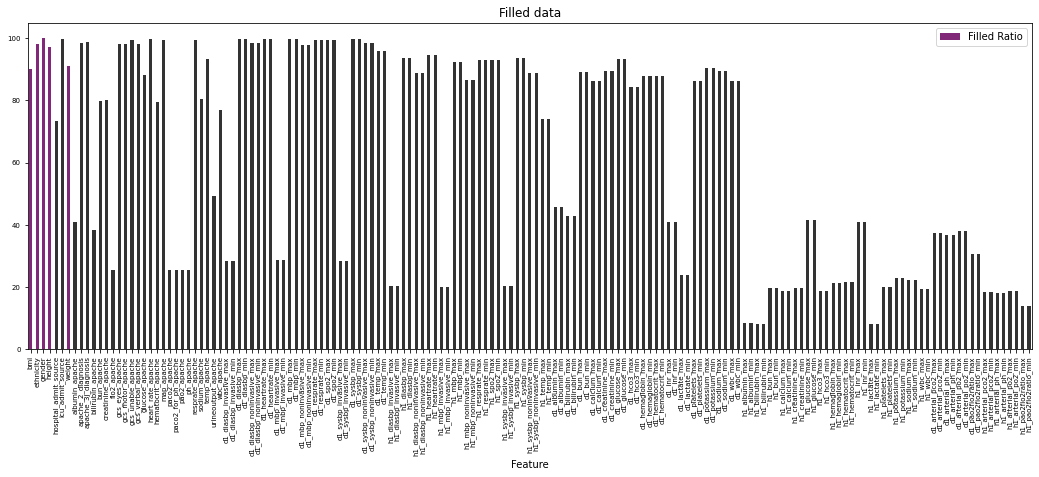

In [13]:
missingData(df_unlabeled)

# Step 1
- identifier: Remove all
- demographic: 
    - Remove icu_id, readmission_status, bmi
    - Impute (knn) age, ethnicity, icu_stay_type, icu_type
    - Impute (knn) pre_icu_los_days
- vitals:
- labs: 
- APACHE covariate: remove all
- APACHE comorbidity: remove all
- labs blood gas: remove all


In [14]:
print(len(df.columns), df.columns.values)

180 ['encounter_id' 'hospital_id' 'age' 'bmi' 'elective_surgery' 'ethnicity'
 'gender' 'height' 'hospital_admit_source' 'icu_admit_source' 'icu_id'
 'icu_stay_type' 'icu_type' 'pre_icu_los_days' 'readmission_status'
 'weight' 'albumin_apache' 'apache_2_diagnosis' 'apache_3j_diagnosis'
 'apache_post_operative' 'arf_apache' 'bilirubin_apache' 'bun_apache'
 'creatinine_apache' 'fio2_apache' 'gcs_eyes_apache' 'gcs_motor_apache'
 'gcs_unable_apache' 'gcs_verbal_apache' 'glucose_apache'
 'heart_rate_apache' 'hematocrit_apache' 'intubated_apache' 'map_apache'
 'paco2_apache' 'paco2_for_ph_apache' 'pao2_apache' 'ph_apache'
 'resprate_apache' 'sodium_apache' 'temp_apache' 'urineoutput_apache'
 'ventilated_apache' 'wbc_apache' 'd1_diasbp_invasive_max'
 'd1_diasbp_invasive_min' 'd1_diasbp_max' 'd1_diasbp_min'
 'd1_diasbp_noninvasive_max' 'd1_diasbp_noninvasive_min'
 'd1_heartrate_max' 'd1_heartrate_min' 'd1_mbp_invasive_max'
 'd1_mbp_invasive_min' 'd1_mbp_max' 'd1_mbp_min' 'd1_mbp_noninvasive_max

## 1. Identifier variables
**STRATEGY**
Drop the identifiers

In [15]:
def processIdentifierVars(df):
    df_ = df[['encounter_id', 'hospital_id']] 
    df = df_.drop(columns = ['encounter_id', 'hospital_id']) #drop columns with all unique 
    print(df.shape)
    return df

In [16]:
df_ids = processIdentifierVars(df)
df_unlabeled_ids = processIdentifierVars(df_unlabeled)

(130157, 0)
(10234, 0)


## 2. Demographic -1  variables
**STRATEGY**

1. IMPUTE
    - **ethnicity, gender (categorical variables)**: Encode + knn impute + Inverse Transform + Convert to dummy variables
    - **weight, height, age** (numerical variables): Knn impute
2. CONVERT AGE to age_groups and then to dummy variables

### preprocess data: 'ethnicity', 'gender': Encode, KNN Impute, Inverse Transform, Convert to dummy variables

In [17]:
DEMO1_COLUMNS_TO_INCLUDE = ['age', 'ethnicity', 'gender', 'height', 'weight']  #drop derived columns (bmi)
DEMO1_CAT_COLUMNS_TO_INCLUDE = ['ethnicity', 'gender']
DEMO1_NUM_COLUMNS_TO_INCLUDE = ['height', 'weight']

In [18]:
encoders_demo1 = {}
def labelEncode(df, col, le=None):
    print(f"{col} Before LE: {df[col].isnull().sum()} {df[col].unique()}")
    df[col] = df[col].fillna(np.nan) 
    df_original = df[col]
    df_mask = df[col].isnull()
    #print(df_mask.sum())

    #df[col] = df[[col]].apply(LabelEncoder().fit_transform)
    df[col] = df[col].astype('str')
    if le == None:
        le = LabelEncoder()
        le.fit(df[col])
        encoders_demo1[col] = le

    df[col] = le.transform(df[col])

    df[col] = df[col].where(~df_mask)#, df_original)
    #df[col] = df[col].apply(lambda x: int(x) if not pd.isnull(x) else np.nan)
    #df[col] = df[col].astype('int')
    #print(df[col].isnull().sum(), f"{df[col].unique()}")
    print(f"{col} After LE: {df[col].isnull().sum()} {df[col].unique()}")
    return df

def processDemographic1Vars(df, msg):
    df_ = df[DEMO1_COLUMNS_TO_INCLUDE]
    printDFDetails(f"processDemographic1Vars - {msg} Before:", df_)

    print("\n==>MISSING DATA")
    df_.shape
    missing_df = missingData(df_)

    # LABEL ENCODE CAT VARS
    print("\n==>LABEL ENCODE CAT VARS")
    for col in DEMO1_CAT_COLUMNS_TO_INCLUDE:
        df_ = labelEncode(df_, col, encoders_demo1.get(col, None))
        print()
    printDFGroups(df_, DEMO1_CAT_COLUMNS_TO_INCLUDE)

    imputeValues = {} # Store the indices of the rows which have NaN values
    for col in DEMO1_COLUMNS_TO_INCLUDE:
        imputeValues[col] = list(df_[df_[col].isnull()][col].index[0:3].values)

    # IMPUTE
    print("\n==>IMPUTE")
    print("Before Impute:", df_.shape, df_.isna().sum().sum(), df_.select_dtypes('object').columns, df_.columns)
    data = df_.values
    ix = [i for i in range(data.shape[1])]
    X = data[:, ix]
    print("Shape:", X.shape)

    knn_imputer = KNNImputer(n_neighbors=2, weights="uniform")
    tic = datetime.now()
    knn_imputer.fit(X)
    np = knn_imputer.transform(X)
    toc = datetime.now()
    print(f"KNN Imputer {toc-tic} sec")

    df = pd.DataFrame(np, columns = DEMO1_COLUMNS_TO_INCLUDE)
    print("After Impute:", df.shape, df.isna().sum().sum(), df.select_dtypes('object').columns, df.columns)

    print("Imputed values")
    for col in DEMO1_COLUMNS_TO_INCLUDE:
        print(df[col][imputeValues[col]])

    for col in DEMO1_CAT_COLUMNS_TO_INCLUDE:
        df[col] = df[col].astype(int)
        print(df.groupby(by=col)[col].agg(['count']))
    
    # INVERSE TRANSFORM
    print("\n==>INVERSE TRANSFORM")
    print(df[DEMO1_COLUMNS_TO_INCLUDE][0:10])
    for col in DEMO1_CAT_COLUMNS_TO_INCLUDE:
        #print(type(encoders_demo1[col]))
        df[[col]] = encoders_demo1[col].inverse_transform(df[[col]])

    print("After Inverse Transform:", df.shape, df.isna().sum().sum(), df.select_dtypes('object').columns, df.columns)

    for col in DEMO1_CAT_COLUMNS_TO_INCLUDE:
        print(df.groupby(by=col)[col].agg(['count']))
    
    # CONVERT CAT VARS TO DUMMY VARS
    print("\n==>CONVERT CAT VARS TO DUMMY VARS")
    print(df[DEMO1_CAT_COLUMNS_TO_INCLUDE][0:10])
    df = pd.get_dummies(df, prefix = DEMO1_CAT_COLUMNS_TO_INCLUDE, drop_first=True)
    print(df)

    printDFDetails(f"processDemographic1Vars - {msg} After:", df)
    return df

processDemographic1Vars - df_demo1 Before:: Shape: (130157, 5); Null values: 12181, 8.16%
Columns: Index(['age', 'ethnicity', 'gender', 'height', 'weight'], dtype='object') 
Columns of object type: Index(['ethnicity', 'gender'], dtype='object')

==>MISSING DATA
(130157, 5)
     Feature  Missing Count  Missing Ratio  Filled Ratio
0        age           4988       3.832295     96.167705
1  ethnicity           1587       1.219297     98.780703
2     gender             66       0.050708     99.949292
3     height           2077       1.595765     98.404235
4     weight           3463       2.660633     97.339367
Index(['Feature', 'Missing Count', 'Missing Ratio', 'Filled Ratio'], dtype='object')

==>LABEL ENCODE CAT VARS
ethnicity Before LE: 1587 ['Caucasian' nan 'Hispanic' 'African American' 'Asian' 'Native American'
 'Other/Unknown']
ethnicity After LE: 1587 [ 2. nan  3.  0.  1.  4.  5.]

gender Before LE: 66 ['M' 'F' nan]
gender After LE: 66 [ 1.  0. nan]

            count
ethnicity   

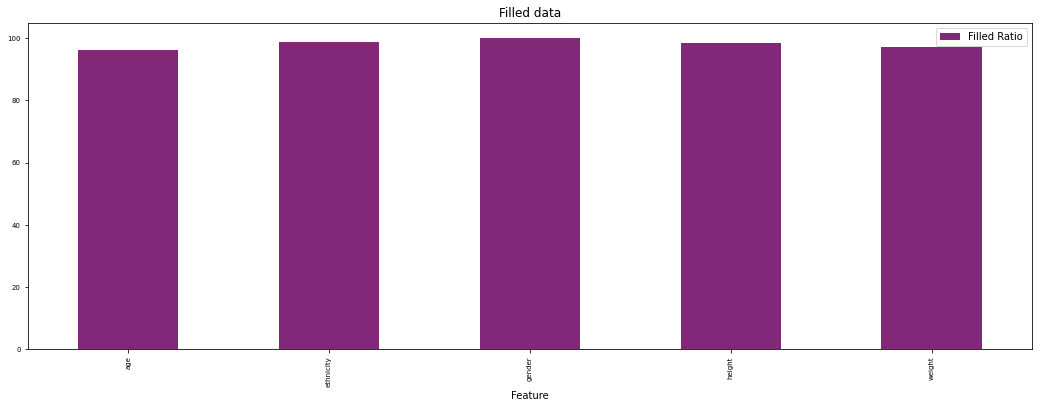

In [19]:
df_demo1 = processDemographic1Vars(df, "df_demo1")

processDemographic1Vars - df_unlabeled_demo1 Before:: Shape: (10234, 5); Null values: 1418, 11.49%
Columns: Index(['age', 'ethnicity', 'gender', 'height', 'weight'], dtype='object') 
Columns of object type: Index(['ethnicity', 'gender'], dtype='object')

==>MISSING DATA
(10234, 5)
     Feature  Missing Count  Missing Ratio  Filled Ratio
0  ethnicity            204       1.993355     98.006645
1     gender              5       0.048857     99.951143
2     height            301       2.941176     97.058824
3     weight            908       8.872386     91.127614
Index(['Feature', 'Missing Count', 'Missing Ratio', 'Filled Ratio'], dtype='object')

==>LABEL ENCODE CAT VARS
ethnicity Before LE: 204 ['Caucasian' nan 'Hispanic' 'Other/Unknown' 'African American' 'Asian'
 'Native American']
ethnicity After LE: 204 [ 2. nan  3.  5.  0.  1.  4.]

gender Before LE: 5 ['F' 'M' nan]
gender After LE: 5 [ 0.  1. nan]

           count
ethnicity       
0.0          931
1.0          171
2.0         793

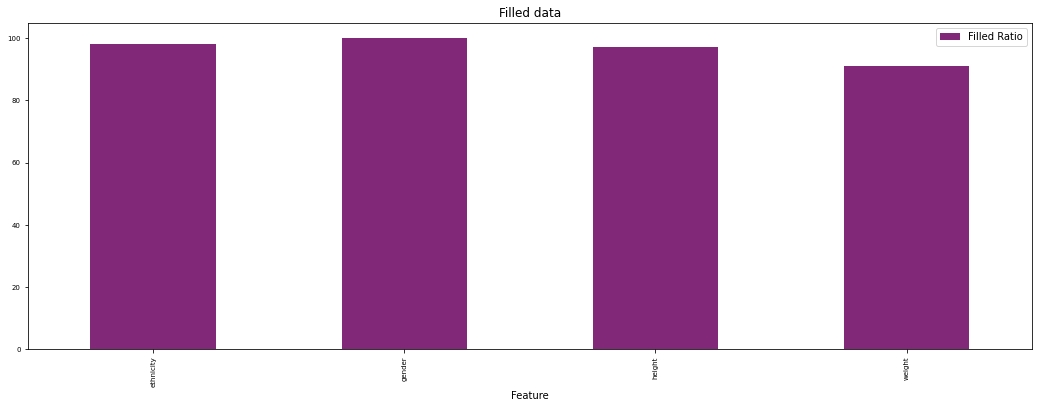

In [20]:
df_unlabeled_demo1 = processDemographic1Vars(df_unlabeled, "df_unlabeled_demo1")

## 3. Demographic -2  variables
**STRATEGY**
- DROP 'icu_id', 'readmission_status' with all unique or same values
- IMPUTE using most_frequent the nan columns **hospital_admit_source, icu_admit_source** 

In [21]:
DEMO2_COLUMNS_TO_INCLUDE = ['elective_surgery', 'hospital_admit_source', 'icu_admit_source', 'icu_id', 'icu_stay_type', 'icu_type','pre_icu_los_days','readmission_status']
DEMO2_CAT_COLUMNS_TO_INCLUDE = ['hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type']
DEMO2_NUM_COLUMNS_TO_INCLUDE = ['elective_surgery', 'pre_icu_los_days']

In [22]:
demo2Impute = None
def processDemographic2Vars(df, demo2Impute, msg):
    df_ = df[DEMO2_COLUMNS_TO_INCLUDE]
    printDFDetails(f"processDemographic2Vars - {msg} Before:",df_)

    # DROP UNIQUE VALUE COLS
    print("\n==>DROP UNIQUE VALUE COLS")
    print(f"Before dropping {df_.shape} {df_.isnull().sum()}")
    df_ = df_.drop(columns = ['icu_id', 'readmission_status']) #drop columns with all unique or same values
    print(f"After dropping {df_.shape} {df_.isnull().sum()}")
    
    print(df_['hospital_admit_source'].unique(), df_['icu_admit_source'].unique())

    print("\n==>MISSING DATA")
    missing_df = missingData(df_)

    imputeValues = {} # Store the indices of the rows which have NaN values
    for col in DEMO2_CAT_COLUMNS_TO_INCLUDE+DEMO2_NUM_COLUMNS_TO_INCLUDE:
        imputeValues[col] = list(df_[df_[col].isnull()][col].index[0:3].values)

    print("\n==>IMPUTE")
    print(f"Before Impute {df_.shape} {df_.isnull().sum().sum()} {df_.select_dtypes('object').columns}")
    df_.replace('?',np.NaN,inplace=True)
    if demo2Impute == None:
        demo2Impute = SimpleImputer(missing_values=np.NaN, strategy='most_frequent')
        demo2Impute.fit(df_)

    df = pd.DataFrame(demo2Impute.transform(df_))
    df.columns = df_.columns
    df.index = df_.index
    print(f"After Impute {df.shape} {df.isnull().sum().sum()} {df_.select_dtypes('object').columns}")

    print("Imputed values")
    for col in DEMO2_CAT_COLUMNS_TO_INCLUDE+DEMO2_NUM_COLUMNS_TO_INCLUDE:
        print(df[col][imputeValues[col]])

    # CONVERT CAT VARS TO DUMMY VARS
    print("\n==>CONVERT CAT VARS TO DUMMY VARS")
    print(df[DEMO2_CAT_COLUMNS_TO_INCLUDE][0:10])
    df = pd.get_dummies(df, columns = DEMO2_CAT_COLUMNS_TO_INCLUDE, prefix = DEMO2_CAT_COLUMNS_TO_INCLUDE, drop_first=True)
    print(df)

    print(df[0:10])
    printDFDetails(f"processDemographic2Vars - {msg} After:", df)
    return df

def processDemographicVars(df1, df2, msg):
    #print("processDemographicVars - Before:", end=" "); printDFDetails(df1)
    df_ = pd.DataFrame()
    df_[df1.columns] = df1
    df_[df2.columns] = df2
    print(df_.shape, df_.isnull().sum(), df_.columns)
    print(df_[0:10])
    printDFDetails(f"processDemographicVars - {msg} After:", df_)
    return df_

processDemographic2Vars - df_demo2 Before:: Shape: (130157, 8); Null values: 33438, 25.51%
Columns: Index(['elective_surgery', 'hospital_admit_source', 'icu_admit_source',
       'icu_id', 'icu_stay_type', 'icu_type', 'pre_icu_los_days',
       'readmission_status'],
      dtype='object') 
Columns of object type: Index(['hospital_admit_source', 'icu_admit_source', 'icu_stay_type',
       'icu_type'],
      dtype='object')

==>DROP UNIQUE VALUE COLS
Before dropping (130157, 8) elective_surgery             0
hospital_admit_source    33198
icu_admit_source           240
icu_id                       0
icu_stay_type                0
icu_type                     0
pre_icu_los_days             0
readmission_status           0
dtype: int64
After dropping (130157, 6) elective_surgery             0
hospital_admit_source    33198
icu_admit_source           240
icu_stay_type                0
icu_type                     0
pre_icu_los_days             0
dtype: int64
['Floor' 'Emergency Department' 

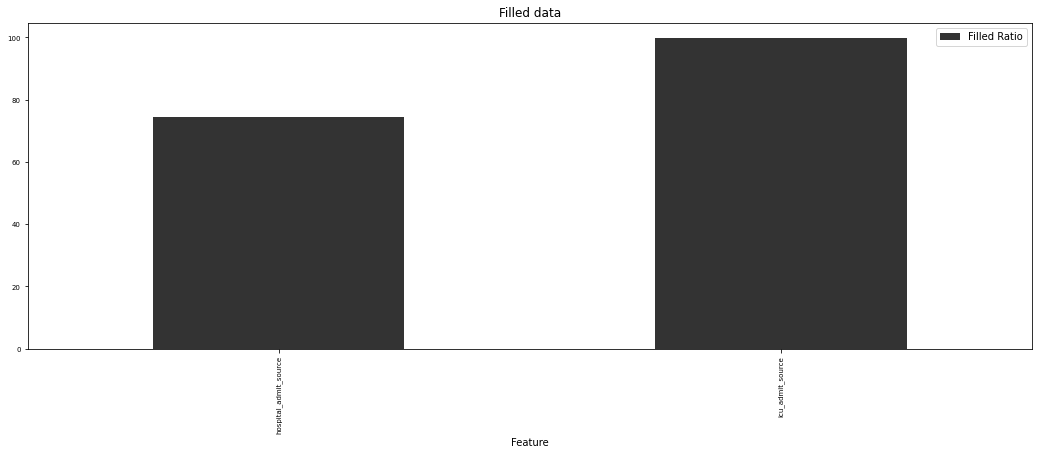

In [23]:
df_demo2 = processDemographic2Vars(df, demo2Impute, "df_demo2")

In [24]:
printDFDetails("df_demo1", df_demo1)
printDFDetails("df_demo2", df_demo2)

df_demo = processDemographicVars(df_demo1, df_demo2, "df_demo")

df_demo1: Shape: (130157, 9); Null values: 0, 0.00%
Columns: Index(['age', 'height', 'weight', 'ethnicity_Asian', 'ethnicity_Caucasian',
       'ethnicity_Hispanic', 'ethnicity_Native American',
       'ethnicity_Other/Unknown', 'gender_M'],
      dtype='object') 
Columns of object type: Index([], dtype='object')
df_demo2: Shape: (130157, 29); Null values: 0, 0.00%
Columns: Index(['elective_surgery', 'pre_icu_los_days',
       'hospital_admit_source_Chest Pain Center',
       'hospital_admit_source_Direct Admit',
       'hospital_admit_source_Emergency Department',
       'hospital_admit_source_Floor', 'hospital_admit_source_ICU',
       'hospital_admit_source_ICU to SDU', 'hospital_admit_source_Observation',
       'hospital_admit_source_Operating Room', 'hospital_admit_source_Other',
       'hospital_admit_source_Other Hospital',
       'hospital_admit_source_Other ICU', 'hospital_admit_source_PACU',
       'hospital_admit_source_Recovery Room',
       'hospital_admit_source_Step-Dow

 ...                           0   
4                                        0  ...                           0   
...                                    ...  ...                         ...   
10229                                    0  ...                           0   
10230                                    0  ...                           0   
10231                                    0  ...                           0   
10232                                    0  ...                           0   
10233                                    0  ...                           0   

       icu_stay_type_readmit  icu_stay_type_transfer  icu_type_CSICU  \
0                          0                       0               0   
1                          0                       0               0   
2                          0                       0               0   
3                          0                       0               0   
4                          0                      

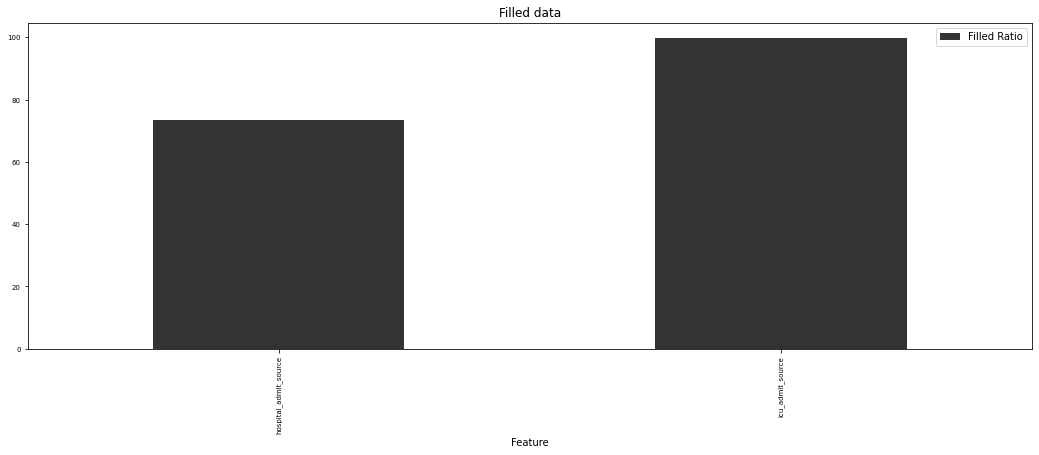

In [25]:
df_unlabeled_demo2 = processDemographic2Vars(df_unlabeled, demo2Impute, "df_unlabeled_demo2")
#print("df_demo2.columns", df_demo2.columns)
#print("df_unlabeled_demo2.columns", df_unlabeled_demo2.columns)
# Some values of categorical values do not occur in the unlabelled data set, so add empty rows
for col in df_demo2.columns:
    if col not in df_unlabeled_demo2.columns:
        print(col)
        df_unlabeled_demo2[col] = 0
print("df_demo2.columns", len(df_demo2.columns))
print("df_unlabeled_demo2.columns", len(df_unlabeled_demo2.columns))

df_unlabeled_demo = processDemographicVars(df_unlabeled_demo1, df_unlabeled_demo2, "df_unlabeled_demo")

## 4. labs
max/min - d1/h1: albumin, bilirubin, bun, calcium, creatinine, glucose, hco3, hemoglobin, hematocrit, inr, lactate, platelets, potassium, sodium, Reduce 60 --> 16 columns

**STRATEGY**

- Drop all of the h1 variables- Except h1_glucose_max and h1_glucose_min
- For h1_glucose_max and h1_glucose_min, we can create a single variable: we can choose to look into one (preferably max)
- Drop all of the d1_{something}_min variable, we can rely on the max variables
- Impute missing values with their corresponding median value
    - For Hemoglobin and Hematocrit based on gender impute median TODO
- For WBC impute with mean TODO

Final Labs variables are all of the d1_{ }_max columns + h1_glucose_average/max = 15 + 1= 16 features 

In [26]:
labImpute = None
def processLabVars(df, labImpute, msg):
    # CONSIDER ONLY D1 MAX AND h1_glucose_max
    LABS_COLUMNS_TO_INCLUDE =['d1_bun_max', 'd1_calcium_max', 'd1_creatinine_max', 'd1_glucose_max',
       'd1_hco3_max', 'd1_hemaglobin_max', 'd1_hematocrit_max', 'd1_inr_max', 'd1_lactate_max', 
       'd1_platelets_max', 'd1_potassium_max', 'd1_sodium_max', 'd1_wbc_max', 
       'd1_arterial_pco2_max', 'd1_arterial_ph_max', 'h1_glucose_max']

    df_ = df[LABS_COLUMNS_TO_INCLUDE]

    printDFDetails(f"processLabVars {msg} - Before:", df_)

    print(df_.shape) # df_[['h1_glucose_max']].isnull().sum()) # df_[df_['h1_glucose_max'].isnull()]['h1_glucose_max'][[0, 2, 3, 4, 5]])
    print(df[['h1_glucose_max']].isnull().sum(), df[['h1_glucose_min']].isnull().sum())

    print("\n==> Combine h1_glucose_max & h1_glucose_min into h1_glucose_avg")
    print("Before Impute: max and min values:", df[['h1_glucose_max', 'h1_glucose_min']][0:5])
    df_['h1_glucose_max'] = df['h1_glucose_max']
    df_['d1_glucose_max'] = df['d1_glucose_max']
    df_['h1_glucose_min'] = df['h1_glucose_min']
    df_['d1_glucose_min'] = df['d1_glucose_min']
    df_['h1_glucose_avg'] = df[['h1_glucose_max', 'h1_glucose_min']].mean(axis=1)
    df_['d1_glucose_evg'] = df[['d1_glucose_max', 'd1_glucose_min']].mean(axis=1)
    df_['h1d1_glucose_max'] = abs(df['h1_glucose_max'] - df['d1_glucose_max'])
    df_['h1d1_glucose_min'] = abs(df['h1_glucose_min'] - df['d1_glucose_min'])
    df_['h1d1_glucose_std'] = df[['d1_glucose_max', 'd1_glucose_min','h1_glucose_max', 'h1_glucose_min']].std(axis=1)
    LABS_COLUMNS_TO_INCLUDE.extend(['h1_glucose_min', 'd1_glucose_min','h1_glucose_max', 'd1_glucose_max', 'd1_glucose_evg', 'h1_glucose_avg', 'h1d1_glucose_max', 'h1d1_glucose_min','h1d1_glucose_std'])

    print("After Impute: max values:", df_['h1_glucose_max'][0:5])

    print("\n==> MISSING DATA")
    missingData(df_)

    print("\n==>IMPUTE")
    imputeValues = {} # Store the indices of the rows which have NaN values
    for col in LABS_COLUMNS_TO_INCLUDE:
        imputeValues[col] = list(df_[df_[col].isnull()][col].index[0:3].values)

    print("Before impute:")
    print(imputeValues)

    df_.replace('?',np.NaN,inplace=True)
    if labImpute == None:
        labImpute = SimpleImputer(missing_values=np.NaN, strategy='median')
        labImpute.fit(df_)

    df = pd.DataFrame(labImpute.transform(df_))
    df.columns = df_.columns
    df.index = df_.index

    print("\n==> AFTER IMPUTE")
    missingData(df)
    for col in LABS_COLUMNS_TO_INCLUDE:
        print(df[col][imputeValues[col]])

    printDFDetails(f"processLabVars {msg} - After:", df)
    return df

processLabVars df_labs - Before:: Shape: (130157, 16); Null values: 586668, 94.62%
Columns: Index(['d1_bun_max', 'd1_calcium_max', 'd1_creatinine_max', 'd1_glucose_max',
       'd1_hco3_max', 'd1_hemaglobin_max', 'd1_hematocrit_max', 'd1_inr_max',
       'd1_lactate_max', 'd1_platelets_max', 'd1_potassium_max',
       'd1_sodium_max', 'd1_wbc_max', 'd1_arterial_pco2_max',
       'd1_arterial_ph_max', 'h1_glucose_max'],
      dtype='object') 
Columns of object type: Index([], dtype='object')
(130157, 16)
h1_glucose_max    75073
dtype: int64 h1_glucose_min    75073
dtype: int64

==> Combine h1_glucose_max & h1_glucose_min into h1_glucose_avg
Before Impute: max and min values:    h1_glucose_max  h1_glucose_min
0             NaN             NaN
1           145.0           143.0
2             NaN             NaN
3             NaN             NaN
4             NaN             NaN
After Impute: max values: 0      NaN
1    145.0
2      NaN
3      NaN
4      NaN
Name: h1_glucose_max, dtype: flo

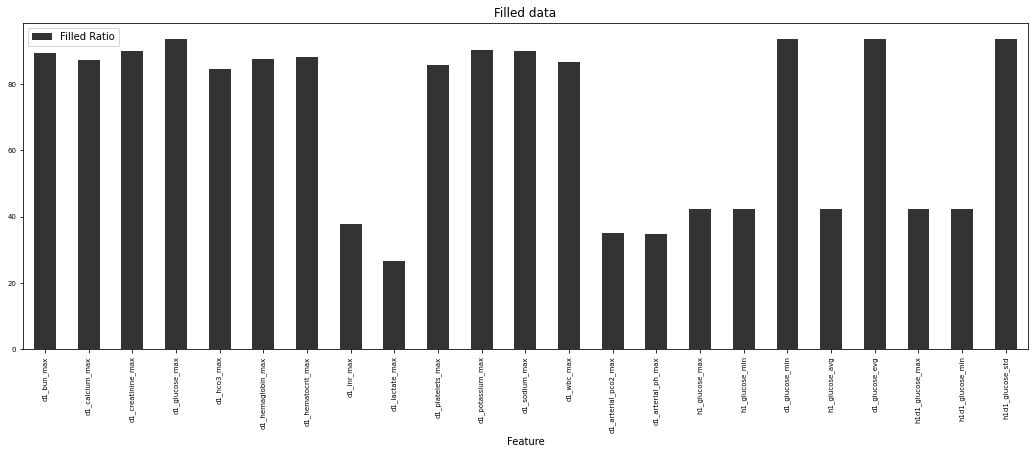

In [27]:
df_labs = processLabVars(df, labImpute, "df_labs")

processLabVars df_unlabeled_labs - Before:: Shape: (10234, 16); Null values: 45920, 94.12%
Columns: Index(['d1_bun_max', 'd1_calcium_max', 'd1_creatinine_max', 'd1_glucose_max',
       'd1_hco3_max', 'd1_hemaglobin_max', 'd1_hematocrit_max', 'd1_inr_max',
       'd1_lactate_max', 'd1_platelets_max', 'd1_potassium_max',
       'd1_sodium_max', 'd1_wbc_max', 'd1_arterial_pco2_max',
       'd1_arterial_ph_max', 'h1_glucose_max'],
      dtype='object') 
Columns of object type: Index([], dtype='object')
(10234, 16)
h1_glucose_max    5990
dtype: int64 h1_glucose_min    5990
dtype: int64

==> Combine h1_glucose_max & h1_glucose_min into h1_glucose_avg
Before Impute: max and min values:    h1_glucose_max  h1_glucose_min
0           104.0           104.0
1             NaN             NaN
2            84.0            84.0
3             NaN             NaN
4           149.0           149.0
After Impute: max values: 0    104.0
1      NaN
2     84.0
3      NaN
4    149.0
Name: h1_glucose_max, dtype

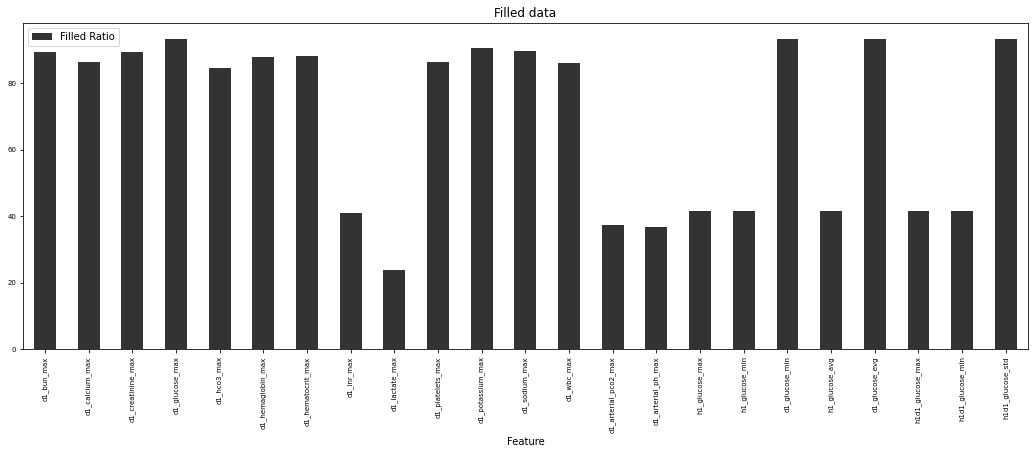

In [28]:
df_unlabeled_labs = processLabVars(df_unlabeled, labImpute, "df_unlabeled_labs")
#print(df_.shape, df_[['h1_glucose_max']].isnull().sum(), df_[df_['h1_glucose_max'].isnull()]['h1_glucose_max'][[3, 5, 6, 7]])

## 5. vitals - non-bp
- max/min - d1/h1: heartrate, resprate, spo2, temp 16 columns

**STRATEGY**

- Remove the rows where a single vital measurement is also not present(excluding BP)- 168 such records. **TODO**
- Treating the h1 empty columns by imputing with data from d1(day-24 hours) and vice versa
- Post this simple impute with Median values

In [29]:
VITALS_BP_COLUMNS_TO_INCLUDE = [
        'd1_diasbp_invasive_max', 'd1_diasbp_invasive_min', 'd1_diasbp_max', 'd1_diasbp_min', 
        'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 'd1_mbp_invasive_max', 'd1_mbp_invasive_min', 
        'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min',
        'd1_sysbp_invasive_max', 'd1_sysbp_invasive_min', 'd1_sysbp_max', 'd1_sysbp_min', 
        'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min',
        'h1_diasbp_invasive_max', 'h1_diasbp_invasive_min', 'h1_diasbp_max', 'h1_diasbp_min', 
        'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min', 'h1_mbp_invasive_max', 'h1_mbp_invasive_min', 'h1_mbp_max', 'h1_mbp_min',
        'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min', 'h1_sysbp_invasive_max', 'h1_sysbp_invasive_min', 
        'h1_sysbp_max', 'h1_sysbp_min', 'h1_sysbp_noninvasive_max', 'h1_sysbp_noninvasive_min']

VITALS_NONBP_COLUMNS_TO_INCLUDE = [
        'd1_heartrate_max', 'd1_heartrate_min', 'd1_resprate_max', 'd1_resprate_min', 
        'd1_spo2_max', 'd1_spo2_min', 'd1_temp_max', 'd1_temp_min', 
        'h1_heartrate_max', 'h1_heartrate_min', 'h1_resprate_max', 'h1_resprate_min', 
        'h1_spo2_max', 'h1_spo2_min', 'h1_temp_max', 'h1_temp_min']

In [30]:
print(len(VITALS_BP_COLUMNS_TO_INCLUDE), len(VITALS_NONBP_COLUMNS_TO_INCLUDE))

36 16


In [31]:
def updateCol1ByCol2(df, col1, col2):
    befCol1 = df[col1].isnull().sum(); befCol2 = df[col2].isnull().sum()
    #print(f"Before imputation: {col1}: {df[col1].isnull().sum()} | {col2}: {df[col2].isnull().sum()} ")
    df.loc[df[col1].isnull(),col1] = df[col2]
    df.loc[df[col2].isnull(),col2] = df[col1]
    print(f"After imputation: {col1}: {befCol1} --> {df[col1].isnull().sum()} | {col2}: {befCol2} --> {df[col2].isnull().sum()} ")
    return df

vitalsNonbpImpute = None
def processVitalsNonbp(df, vitalsNonbpImpute, msg):
    df_ = df[VITALS_NONBP_COLUMNS_TO_INCLUDE]
    printDFDetails(f"processVitalsNonbp - {msg} Before:", df_)
    msno.bar(df_)
    #print(f"Before Imputation, Count of rows with atleast 1 NaN: {nanRows(df_)}")

    imputeValues = {} # Store the indices of the rows which have NaN values
    for col in VITALS_NONBP_COLUMNS_TO_INCLUDE:
        imputeValues[col] = list(df_[df_[col].isnull()][col].index[0:3].values)

    # Treating the h1 empty columns by imputing with data from d1(day-24 hours)
    df_ = updateCol1ByCol2(df_, 'h1_temp_max', 'd1_temp_max')
    df_ = updateCol1ByCol2(df_, 'h1_temp_min', 'd1_temp_min')
    df_ = updateCol1ByCol2(df_, 'h1_spo2_max', 'd1_spo2_max')
    df_ = updateCol1ByCol2(df_, 'h1_spo2_min', 'd1_spo2_min')
    df_ = updateCol1ByCol2(df_, 'h1_heartrate_max', 'd1_heartrate_max')
    df_ = updateCol1ByCol2(df_, 'h1_heartrate_min', 'd1_heartrate_min')
    df_ = updateCol1ByCol2(df_, 'h1_resprate_max', 'd1_resprate_max')
    df_ = updateCol1ByCol2(df_, 'h1_resprate_min', 'd1_resprate_min')

    #print(f"After Imputation - 1, Count of rows with atleast 1 NaN: {nanRows(df_)}")
    printDFDetails(f"After Imputation - {msg} 1", df_)

    df_.replace('?',np.NaN,inplace=True)
    if vitalsNonbpImpute == None:
        vitalsNonbpImpute = SimpleImputer(missing_values=np.NaN, strategy='median')
        vitalsNonbpImpute.fit(df_)

    df = pd.DataFrame(vitalsNonbpImpute.transform(df_))
    df.columns = df_.columns
    df.index = df_.index

    print("Imputed values")
    for col in VITALS_NONBP_COLUMNS_TO_INCLUDE:
        print(df[col][imputeValues[col]])

    msno.bar(df)

    #print(f"After Imputation - 2, Count of rows with atleast 1 NaN: {nanRows(df)}")
    printDFDetails(f"processVitalsNonbp - {msg} After:", df)
    return df


processVitalsNonbp - df_vitals_nonbp Before:: Shape: (130157, 16); Null values: 104888, 25.96%
Columns: Index(['d1_heartrate_max', 'd1_heartrate_min', 'd1_resprate_max',
       'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min', 'd1_temp_max',
       'd1_temp_min', 'h1_heartrate_max', 'h1_heartrate_min',
       'h1_resprate_max', 'h1_resprate_min', 'h1_spo2_max', 'h1_spo2_min',
       'h1_temp_max', 'h1_temp_min'],
      dtype='object') 
Columns of object type: Index([], dtype='object')
After imputation: h1_temp_max: 29703 --> 4494 | d1_temp_max: 4494 --> 4494 
After imputation: h1_temp_min: 29703 --> 4494 | d1_temp_min: 4494 --> 4494 
After imputation: h1_spo2_max: 6242 --> 532 | d1_spo2_max: 532 --> 532 
After imputation: h1_spo2_min: 6242 --> 532 | d1_spo2_min: 532 --> 532 
After imputation: h1_heartrate_max: 4074 --> 262 | d1_heartrate_max: 262 --> 262 
After imputation: h1_heartrate_min: 4074 --> 262 | d1_heartrate_min: 262 --> 262 
After imputation: h1_resprate_max: 6454 --> 683 | d

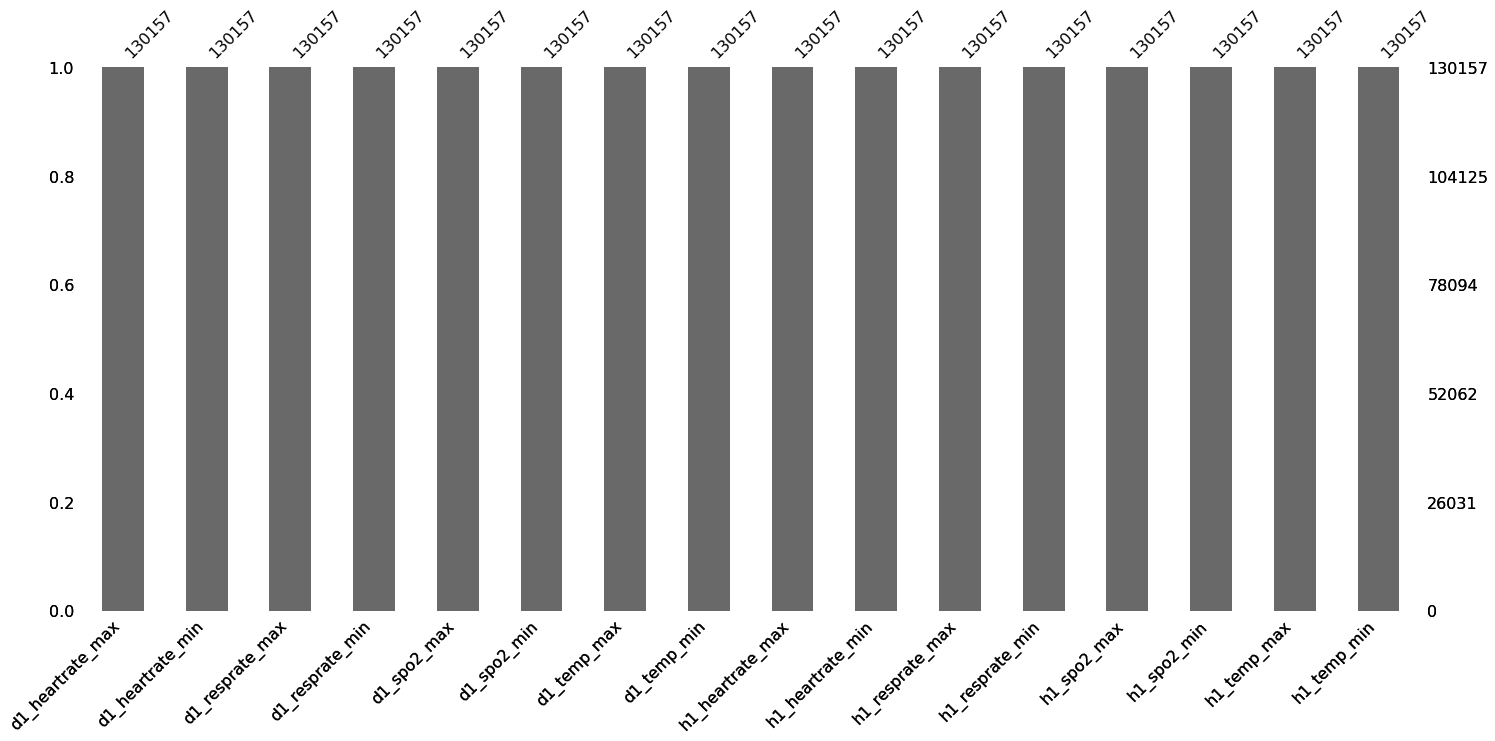

In [32]:
df_vitals_nonbp = processVitalsNonbp(df, vitalsNonbpImpute, "df_vitals_nonbp")
print(df_vitals_nonbp.isnull().sum())
# Wherever d1 is missing h1 is also missing

processVitalsNonbp - df_unlabeled_vitals_nonbp Before:: Shape: (10234, 16); Null values: 10452, 29.58%
Columns: Index(['d1_heartrate_max', 'd1_heartrate_min', 'd1_resprate_max',
       'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min', 'd1_temp_max',
       'd1_temp_min', 'h1_heartrate_max', 'h1_heartrate_min',
       'h1_resprate_max', 'h1_resprate_min', 'h1_spo2_max', 'h1_spo2_min',
       'h1_temp_max', 'h1_temp_min'],
      dtype='object') 
Columns of object type: Index([], dtype='object')
After imputation: h1_temp_max: 2654 --> 430 | d1_temp_max: 430 --> 430 
After imputation: h1_temp_min: 2654 --> 430 | d1_temp_min: 430 --> 430 
After imputation: h1_spo2_max: 726 --> 62 | d1_spo2_max: 62 --> 62 
After imputation: h1_spo2_min: 726 --> 62 | d1_spo2_min: 62 --> 62 
After imputation: h1_heartrate_max: 551 --> 24 | d1_heartrate_max: 24 --> 24 
After imputation: h1_heartrate_min: 551 --> 24 | d1_heartrate_min: 24 --> 24 
After imputation: h1_resprate_max: 724 --> 55 | d1_resprate_max: 55

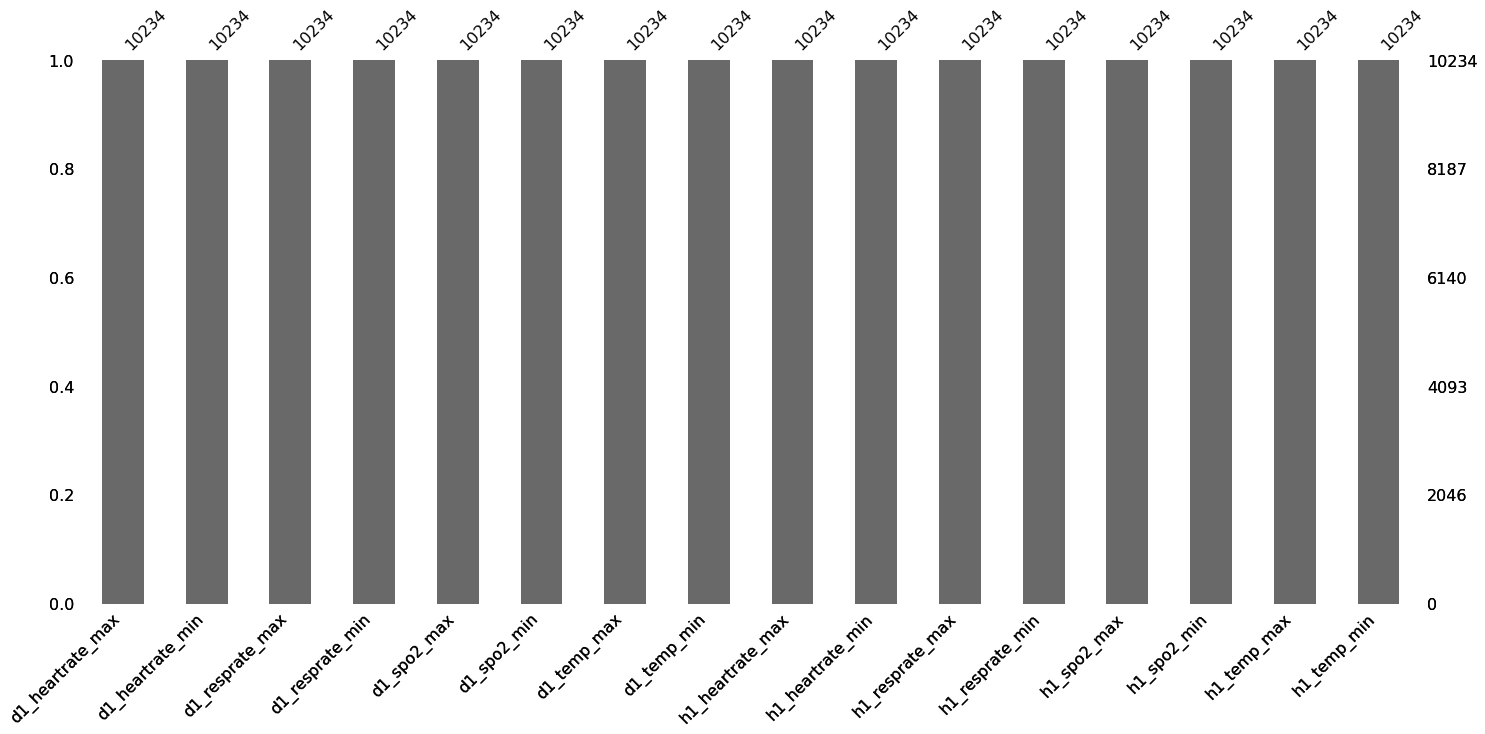

In [33]:
df_unlabeled_vitals_nonbp = processVitalsNonbp(df_unlabeled, vitalsNonbpImpute, "df_unlabeled_vitals_nonbp")
# Wherever d1 is missing h1 is also missing

Remove these rows?

## 6. vitals - bp 
- diasbp/mbp/sysbp - invasive/non-invasive/general - max-min - d1/h1: Reduce 36 --> 12 columns

**STRATEGY**

- IMPUTE non-invasive with General and invasive with non-invasive
- IMPUTE the h1 empty columns with data from d1(day-24 hours) and vice versa
- Post this simple impute with Median values
- DROP non-invasive and general

In [34]:
def imputeInvNoninvGen(df, invCol, nonInvCol, genCol):
    #print(f"Before imputation: {invCol}: {df[invCol].isnull().sum()} | {nonInvCol}: {df[nonInvCol].isnull().sum()} | {genCol}: {df[genCol].isnull().sum()}")
    befinvCol = df[invCol].isnull().sum(); befnonInvCol = df[nonInvCol].isnull().sum(); befgenCol = df[genCol].isnull().sum()
    #print(df.columns)
    df.loc[df[nonInvCol].isnull(),nonInvCol] = df[genCol]
    df.loc[df[invCol].isnull(),invCol] = df[nonInvCol]
    df_ = df.drop(columns=[nonInvCol,genCol])
    #print(df_.columns)
    print(f"After imputation: {invCol}: {befinvCol} --> {df[invCol].isnull().sum()} | {nonInvCol}: {befnonInvCol} --> {df[nonInvCol].isnull().sum()} | {genCol}: {befgenCol} --> {df[genCol].isnull().sum()}")
    return df_

vitalsBpImpute = None
def processVitalsbp(df, vitalsBpImpute, msg):
    df_ = df[VITALS_BP_COLUMNS_TO_INCLUDE]

    printDFDetails(f"processVitalsbp - {msg} Before:",df_)

    msno.bar(df_)
    #print(f"Before Imputation, Count of rows with atleast 1 NaN: {nanRows(df_)}")

    imputeValues = {} # Store the indices of the rows which have NaN values
    for col in VITALS_BP_COLUMNS_TO_INCLUDE:
        imputeValues[col] = list(df_[df_[col].isnull()][col].index[0:3].values)

    df_ = imputeInvNoninvGen(df_, 'd1_diasbp_invasive_max', 'd1_diasbp_noninvasive_max', 'd1_diasbp_max' )
    df_ = imputeInvNoninvGen(df_, 'd1_diasbp_invasive_min', 'd1_diasbp_noninvasive_min', 'd1_diasbp_min' )
    df_ = imputeInvNoninvGen(df_, 'h1_diasbp_invasive_max', 'h1_diasbp_noninvasive_max', 'h1_diasbp_max' )
    df_ = imputeInvNoninvGen(df_, 'h1_diasbp_invasive_min', 'h1_diasbp_noninvasive_min', 'h1_diasbp_min' )

    df_ = imputeInvNoninvGen(df_, 'd1_mbp_invasive_max', 'd1_mbp_noninvasive_max', 'd1_mbp_max' )
    df_ = imputeInvNoninvGen(df_, 'd1_mbp_invasive_min', 'd1_mbp_noninvasive_min', 'd1_mbp_min' )
    df_ = imputeInvNoninvGen(df_, 'h1_mbp_invasive_max', 'h1_mbp_noninvasive_max', 'h1_mbp_max' )
    df_ = imputeInvNoninvGen(df_, 'h1_mbp_invasive_min', 'h1_mbp_noninvasive_min', 'h1_mbp_min' )

    df_ = imputeInvNoninvGen(df_, 'd1_sysbp_invasive_max', 'd1_sysbp_noninvasive_max', 'd1_sysbp_max' )
    df_ = imputeInvNoninvGen(df_, 'd1_sysbp_invasive_min', 'd1_sysbp_noninvasive_min', 'd1_sysbp_min' )
    df_ = imputeInvNoninvGen(df_, 'h1_sysbp_invasive_max', 'h1_sysbp_noninvasive_max', 'h1_sysbp_max' )
    df_ = imputeInvNoninvGen(df_, 'h1_sysbp_invasive_min', 'h1_sysbp_noninvasive_min', 'h1_sysbp_min' )

    #print(f"After Imputation - 1, Count of rows with atleast 1 NaN: {nanRows(df_)}")
    printDFDetails(f"After Imputation - {msg} 1",df_)

    df_ = updateCol1ByCol2(df_, 'h1_diasbp_invasive_max', 'd1_diasbp_invasive_max')
    df_ = updateCol1ByCol2(df_, 'h1_diasbp_invasive_min', 'd1_diasbp_invasive_min')
    df_ = updateCol1ByCol2(df_, 'h1_mbp_invasive_max', 'd1_mbp_invasive_max')
    df_ = updateCol1ByCol2(df_, 'h1_mbp_invasive_min', 'd1_mbp_invasive_min')
    df_ = updateCol1ByCol2(df_, 'h1_sysbp_invasive_max', 'd1_sysbp_invasive_max')
    df_ = updateCol1ByCol2(df_, 'h1_sysbp_invasive_min', 'd1_sysbp_invasive_min')

    printDFDetails(f"After Imputation - {msg} 2",df_)

    df_.replace('?',np.NaN,inplace=True)
    if vitalsBpImpute == None:
        vitalsBpImpute = SimpleImputer(missing_values=np.NaN, strategy='median')
        vitalsBpImpute.fit(df_)

    df = pd.DataFrame(vitalsBpImpute.transform(df_))
    df.columns = df_.columns
    df.index = df_.index

    print("Imputed values")
    for col in ['d1_diasbp_invasive_max', 'd1_diasbp_invasive_min', 'h1_diasbp_invasive_max', 'h1_diasbp_invasive_min',
                'd1_mbp_invasive_max', 'd1_mbp_invasive_min', 'h1_mbp_invasive_max', 'h1_mbp_invasive_min',
                'd1_sysbp_invasive_max', 'd1_sysbp_invasive_min', 'h1_sysbp_invasive_min',  'd1_sysbp_invasive_min']:
        print(df[col][imputeValues[col]])

    msno.bar(df)

    #print(f"After Imputation-3, Count of rows with atleast 1 NaN: {nanRows(df)}")
    printDFDetails(f"processVitalsbp - {msg} After:", df)

    return df

processVitalsbp - df_vitals_bp Before:: Shape: (130157, 36); Null values: 1318560, 86.00%
Columns: Index(['d1_diasbp_invasive_max', 'd1_diasbp_invasive_min', 'd1_diasbp_max',
       'd1_diasbp_min', 'd1_diasbp_noninvasive_max',
       'd1_diasbp_noninvasive_min', 'd1_mbp_invasive_max',
       'd1_mbp_invasive_min', 'd1_mbp_max', 'd1_mbp_min',
       'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min',
       'd1_sysbp_invasive_max', 'd1_sysbp_invasive_min', 'd1_sysbp_max',
       'd1_sysbp_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min',
       'h1_diasbp_invasive_max', 'h1_diasbp_invasive_min', 'h1_diasbp_max',
       'h1_diasbp_min', 'h1_diasbp_noninvasive_max',
       'h1_diasbp_noninvasive_min', 'h1_mbp_invasive_max',
       'h1_mbp_invasive_min', 'h1_mbp_max', 'h1_mbp_min',
       'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min',
       'h1_sysbp_invasive_max', 'h1_sysbp_invasive_min', 'h1_sysbp_max',
       'h1_sysbp_min', 'h1_sysbp_noninvasive_max', 'h1_sysbp_nonin

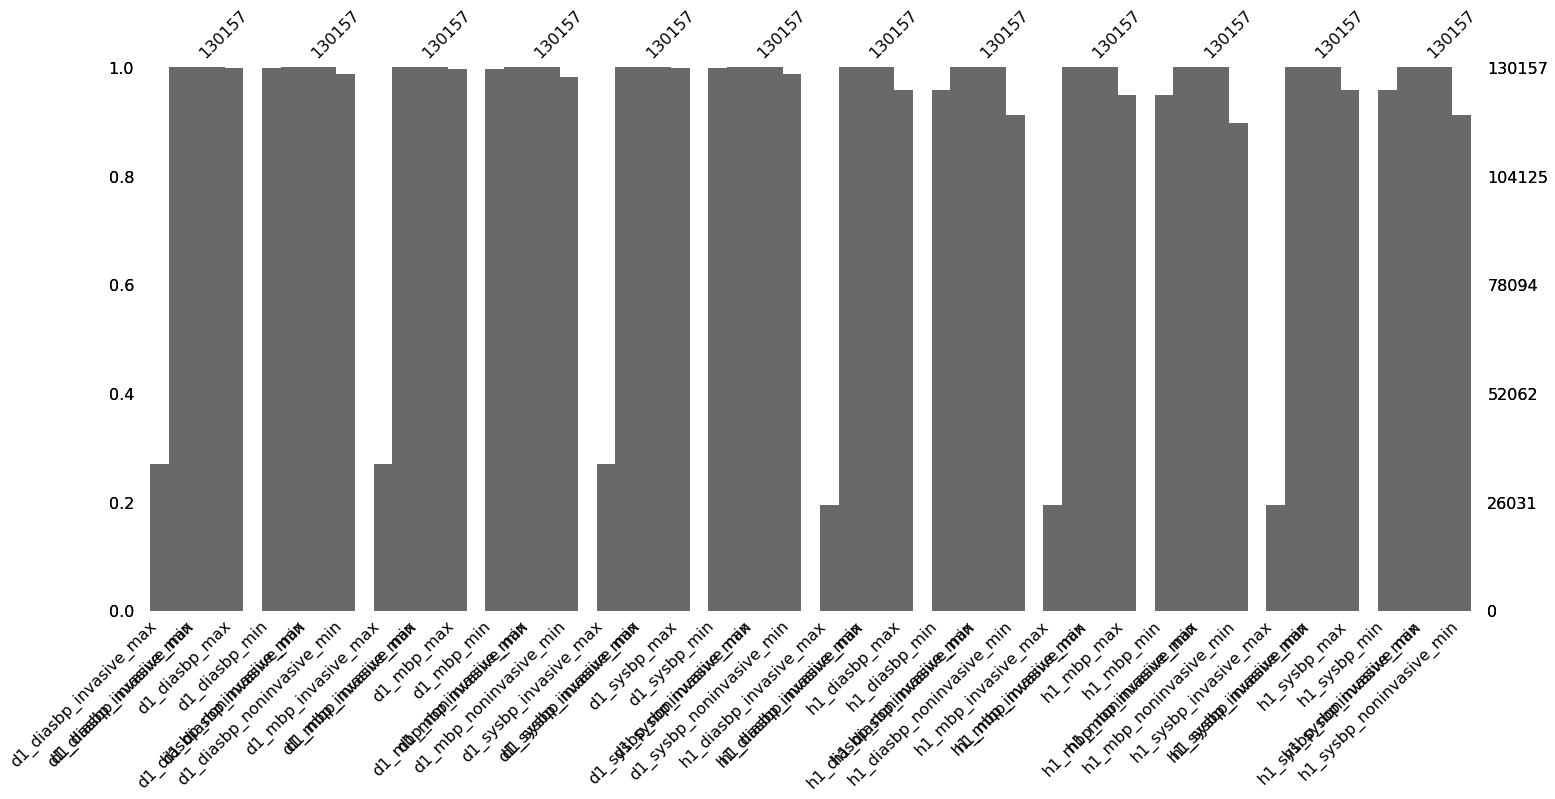

In [35]:
df_vitals_bp = processVitalsbp(df, vitalsBpImpute, "df_vitals_bp")

df_vitals = pd.DataFrame()
df_vitals[df_vitals_nonbp.columns] = df_vitals_nonbp
df_vitals[df_vitals_bp.columns] = df_vitals_bp
print(df_vitals.shape, df_vitals.columns)

processVitalsbp - df_unlabeled_vitals_bp Before:: Shape: (10234, 36); Null values: 105766, 85.95%
Columns: Index(['d1_diasbp_invasive_max', 'd1_diasbp_invasive_min', 'd1_diasbp_max',
       'd1_diasbp_min', 'd1_diasbp_noninvasive_max',
       'd1_diasbp_noninvasive_min', 'd1_mbp_invasive_max',
       'd1_mbp_invasive_min', 'd1_mbp_max', 'd1_mbp_min',
       'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min',
       'd1_sysbp_invasive_max', 'd1_sysbp_invasive_min', 'd1_sysbp_max',
       'd1_sysbp_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min',
       'h1_diasbp_invasive_max', 'h1_diasbp_invasive_min', 'h1_diasbp_max',
       'h1_diasbp_min', 'h1_diasbp_noninvasive_max',
       'h1_diasbp_noninvasive_min', 'h1_mbp_invasive_max',
       'h1_mbp_invasive_min', 'h1_mbp_max', 'h1_mbp_min',
       'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min',
       'h1_sysbp_invasive_max', 'h1_sysbp_invasive_min', 'h1_sysbp_max',
       'h1_sysbp_min', 'h1_sysbp_noninvasive_max', 'h1_sys

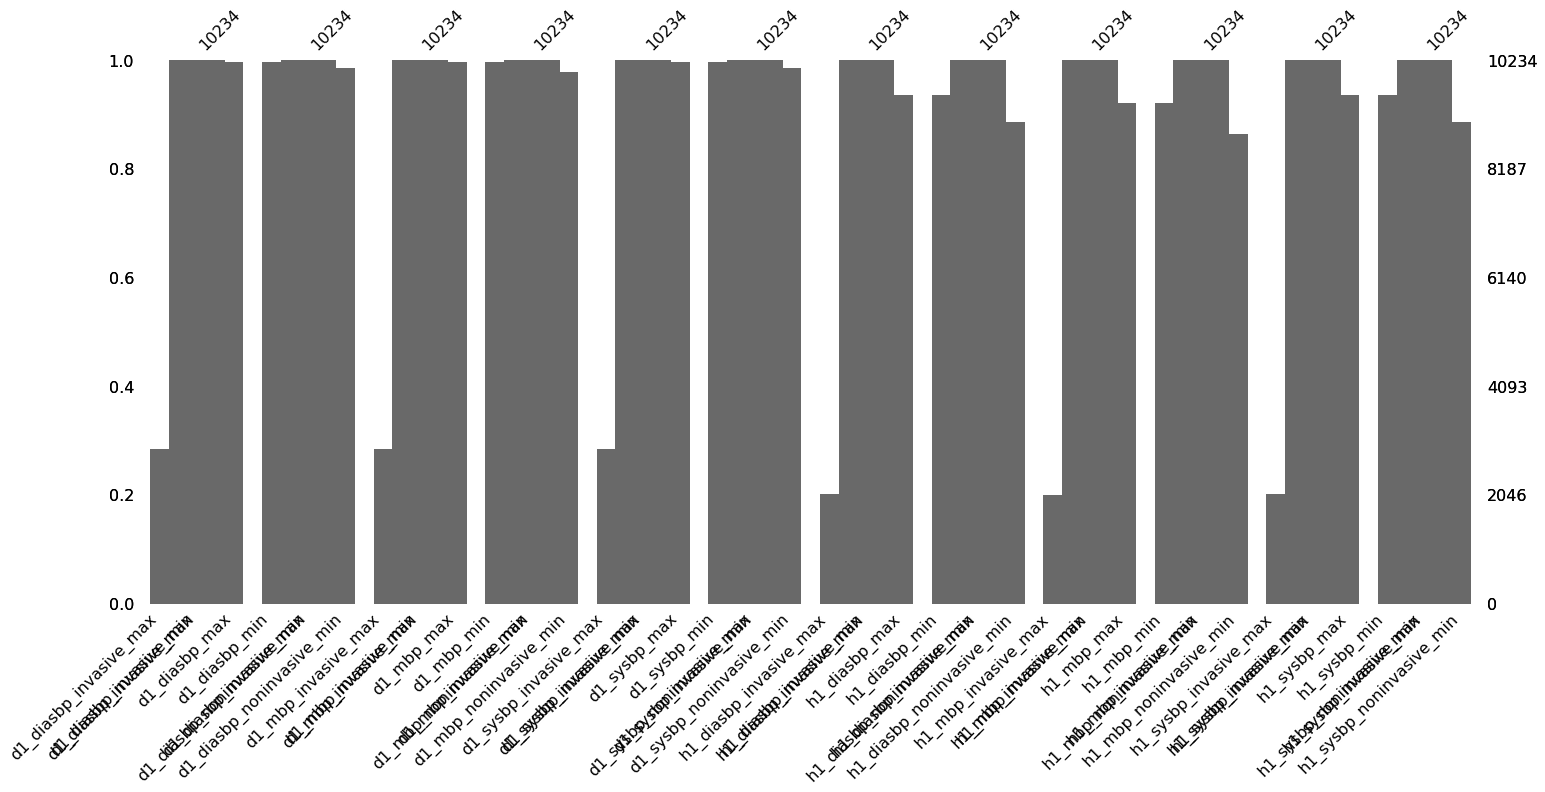

In [36]:
df_unlabeled_vitals_bp = processVitalsbp(df_unlabeled, vitalsBpImpute, "df_unlabeled_vitals_bp")

df_unlabeled_vitals = pd.DataFrame()

df_unlabeled_vitals[df_unlabeled_vitals_nonbp.columns] = df_unlabeled_vitals_nonbp
df_unlabeled_vitals[df_unlabeled_vitals_bp.columns] = df_unlabeled_vitals_bp
print(df_unlabeled_vitals.shape, df_unlabeled_vitals.columns)

## 7. apache comobidities
**STRATEGY**
Combined all the apache comobidities variables into a single variable

In [37]:
df_apch_comorb = df[CAT_COLUMNS['apache_comorbidity']]
df_apch_comorb['comorbidity_score'] = df['aids']*23 + df['cirrhosis']*4  + df['hepatic_failure']*16 + \
                                df['immunosuppression']*10 + df['leukemia']*10 + df['lymphoma']*13 + \
                                df['solid_tumor_with_metastasis']*11
missingData(df_apch_comorb)

(130157, 8)
There are no missing values


""


In [38]:
df_unlabeled_apch_comorb = df_unlabeled[CAT_COLUMNS['apache_comorbidity']]
df_unlabeled_apch_comorb['comorbidity_score'] = df_unlabeled['aids']*23 + df_unlabeled['cirrhosis']*4  + df_unlabeled['hepatic_failure']*16 + \
                        df_unlabeled['immunosuppression']*10 + df_unlabeled['leukemia']*10 + df_unlabeled['lymphoma']*13 + \
                        df_unlabeled['solid_tumor_with_metastasis']*11
missingData(df_unlabeled_apch_comorb)

(10234, 8)
There are no missing values


""


## 8.apache co-variates: 
Include essential: apache_2_diagnosis, apache_3j_diagnosis, intubated_apache, urineoutput_apache, ventilated_apache

(130157, 5)
               Feature  Missing Count  Missing Ratio  Filled Ratio
0   apache_2_diagnosis           1685       1.294590     98.705410
1  apache_3j_diagnosis            865       0.664582     99.335418
2   urineoutput_apache          63167      48.531389     51.468611
Index(['Feature', 'Missing Count', 'Missing Ratio', 'Filled Ratio'], dtype='object')


,apache_2_diagnosis,apache_3j_diagnosis,intubated_apache,urineoutput_apache,ventilated_apache
0,113.0,502.01,0,NaN,0
1,108.0,203.01,0,NaN,1
2,122.0,703.03,0,NaN,0
3,203.0,1206.03,1,NaN,1
4,119.0,601.01,0,NaN,0
5,301.0,403.01,0,NaN,0
6,108.0,203.01,1,NaN,1
7,113.0,501.05,0,NaN,1
8,116.0,103.01,0,NaN,1
9,112.0,107.01,0,NaN,0


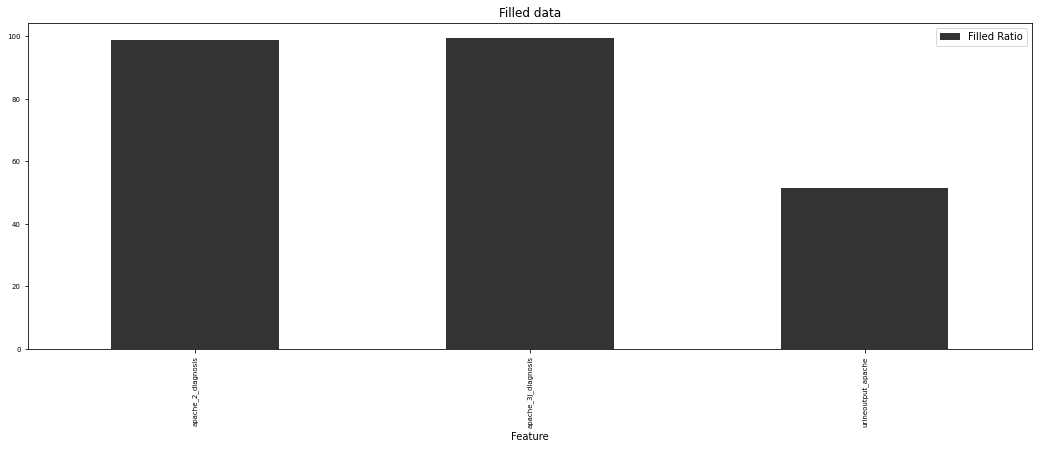

In [39]:
df_apch_covar = df[['apache_2_diagnosis', 'apache_3j_diagnosis', 'intubated_apache', 'urineoutput_apache', 'ventilated_apache']]
missingData(df_apch_covar)
df_apch_covar[0:10]

(10234, 5)
               Feature  Missing Count  Missing Ratio  Filled Ratio
0   apache_2_diagnosis            170       1.661130     98.338870
1  apache_3j_diagnosis            108       1.055306     98.944694
2   urineoutput_apache           5190      50.713309     49.286691
Index(['Feature', 'Missing Count', 'Missing Ratio', 'Filled Ratio'], dtype='object')


,apache_2_diagnosis,apache_3j_diagnosis,intubated_apache,urineoutput_apache,ventilated_apache
0,110.0,104.01,0,NaN,0
1,117.0,106.01,0,NaN,0
2,302.0,109.01,0,NaN,0
3,113.0,501.05,0,NaN,1
4,117.0,106.01,0,NaN,0
5,117.0,106.01,0,NaN,0
6,110.0,104.01,0,NaN,0
7,124.0,305.02,0,NaN,0
8,113.0,501.05,0,NaN,1
9,113.0,502.01,0,NaN,0


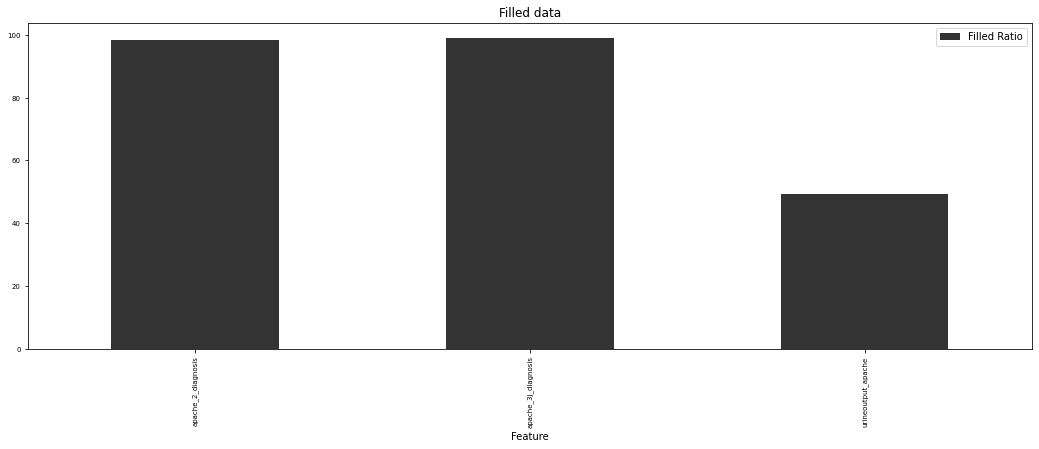

In [40]:
df_unlabeled_apch_covar = df_unlabeled[['apache_2_diagnosis', 'apache_3j_diagnosis', 'intubated_apache', 'urineoutput_apache', 'ventilated_apache']]
missingData(df_unlabeled_apch_covar)
df_unlabeled_apch_covar[0:10]

## Step1

In [41]:
def pickStepFeatures(df_demo, df_labs, df_vitals, df_apch_comorb, df_apch_covar, msg):
    df_ = pd.DataFrame()
    df_[df_demo.columns] = df_demo
    df_[df_labs.columns] = df_labs
    df_[df_vitals.columns] = df_vitals
    if isinstance(df_apch_comorb, pd.DataFrame) and not df_apch_comorb.empty:
        df_[df_apch_comorb.columns] = df_apch_comorb
    if isinstance(df_apch_covar, pd.DataFrame) and not df_apch_covar.empty:
        df_[df_apch_covar.columns] = df_apch_covar
    
    #print(df_.shape, df_.columns, df_[0:10] )
    cols = df_.columns[df_.dtypes.eq('object')]
    #print(len(cols), cols)
    df_[cols] = df_[cols].apply(pd.to_numeric, errors='coerce', axis=1)
    #print(df_.columns)
    printDFDetails(f"pickStepFeatures {msg}", df_)
    return df_

In [42]:
printDFDetails(f"df_step1 df_demo",df_demo)
printDFDetails(f"df_step1 df_labs",df_labs)
printDFDetails(f"df_step1 df_vitals",df_vitals)
df_step1 = pickStepFeatures(df_demo, df_labs, df_vitals, pd.DataFrame(), pd.DataFrame(), "df_step1")
printDFDetails("df_step1", df_step1)

df_step1 df_demo: Shape: (130157, 38); Null values: 0, 0.00%
Columns: Index(['age', 'height', 'weight', 'ethnicity_Asian', 'ethnicity_Caucasian',
       'ethnicity_Hispanic', 'ethnicity_Native American',
       'ethnicity_Other/Unknown', 'gender_M', 'elective_surgery',
       'pre_icu_los_days', 'hospital_admit_source_Chest Pain Center',
       'hospital_admit_source_Direct Admit',
       'hospital_admit_source_Emergency Department',
       'hospital_admit_source_Floor', 'hospital_admit_source_ICU',
       'hospital_admit_source_ICU to SDU', 'hospital_admit_source_Observation',
       'hospital_admit_source_Operating Room', 'hospital_admit_source_Other',
       'hospital_admit_source_Other Hospital',
       'hospital_admit_source_Other ICU', 'hospital_admit_source_PACU',
       'hospital_admit_source_Recovery Room',
       'hospital_admit_source_Step-Down Unit (SDU)', 'icu_admit_source_Floor',
       'icu_admit_source_Operating Room / Recovery',
       'icu_admit_source_Other Hospital'

In [43]:
print(df_demo.columns[df_demo.dtypes.eq('object')])
df_demo[df_demo.columns[df_demo.dtypes.eq('object')]]

Index(['elective_surgery', 'pre_icu_los_days'], dtype='object')


,elective_surgery,pre_icu_los_days
0,0,0.541667
1,0,0.927778
2,0,0.000694
3,1,0.000694
4,0,0.073611
...,...,...
130152,0,0.023611
130153,0,0.009722
130154,0,0.143056
130155,0,0.188194


In [44]:
df_unlabeled_step1 = pickStepFeatures(df_unlabeled_demo, df_unlabeled_labs, df_unlabeled_vitals, pd.DataFrame(), pd.DataFrame(), "df_unlabeled_step1")
printDFDetails("df_unlabeled_step1", df_unlabeled_step1)

pickStepFeatures df_unlabeled_step1: Shape: (10234, 89); Null values: 0, 0.00%
Columns: Index(['age', 'height', 'weight', 'ethnicity_Asian', 'ethnicity_Caucasian',
       'ethnicity_Hispanic', 'ethnicity_Native American',
       'ethnicity_Other/Unknown', 'gender_M', 'elective_surgery',
       'pre_icu_los_days', 'hospital_admit_source_Direct Admit',
       'hospital_admit_source_Emergency Department',
       'hospital_admit_source_Floor', 'hospital_admit_source_ICU to SDU',
       'hospital_admit_source_Operating Room',
       'hospital_admit_source_Other Hospital',
       'hospital_admit_source_Other ICU',
       'hospital_admit_source_Recovery Room',
       'hospital_admit_source_Step-Down Unit (SDU)', 'icu_admit_source_Floor',
       'icu_admit_source_Operating Room / Recovery',
       'icu_admit_source_Other Hospital', 'icu_admit_source_Other ICU',
       'icu_stay_type_readmit', 'icu_stay_type_transfer', 'icu_type_CSICU',
       'icu_type_CTICU', 'icu_type_Cardiac ICU', 'icu_type

In [45]:
#Train the model
'''
xgb = XGBClassifier(n_estimators=400, colsample_bytree=0.7, reg_lambda=120, subsample=0.75) #parameters set after tuning
tic = datetime.now()
xgb = compute_roc_auc(xgb, df_step1, target)
#xgb.fit(df_step1, target) # train on entire dataset for best results
toc = datetime.now()
print(f"xgb.fit {toc-tic} sec")
'''

'\nxgb = XGBClassifier(n_estimators=400, colsample_bytree=0.7, reg_lambda=120, subsample=0.75) #parameters set after tuning\ntic = datetime.now()\nxgb = compute_roc_auc(xgb, df_step1, target)\n#xgb.fit(df_step1, target) # train on entire dataset for best results\ntoc = datetime.now()\nprint(f"xgb.fit {toc-tic} sec")\n'

In [46]:
'''
# Predict
df_unlabeled_step1 = df_unlabeled_step1[df_step1.columns]
unlabeled_pred = xgb.predict(df_unlabeled_step1)
print(len(unlabeled_pred), type(unlabeled_pred), unlabeled_pred)
count = 0
for element in unlabeled_pred:
    if element == 1:
        count += 1

print(f"{count} {100 * (count/df.shape[0]):0.2f}%")

getFeatureImportance(xgb, df_step1)
'''

'\n# Predict\ndf_unlabeled_step1 = df_unlabeled_step1[df_step1.columns]\nunlabeled_pred = xgb.predict(df_unlabeled_step1)\nprint(len(unlabeled_pred), type(unlabeled_pred), unlabeled_pred)\ncount = 0\nfor element in unlabeled_pred:\n    if element == 1:\n        count += 1\n\nprint(f"{count} {100 * (count/df.shape[0]):0.2f}%")\n'

## STEP2: INCLUDE APACHE COMORBIDITIES

In [47]:
printDFDetails("df_demo df_step2",df_demo)
printDFDetails("df_labs df_step2",df_labs)
printDFDetails("df_vitals df_step2",df_vitals)
printDFDetails("df_apch_comorb df_step2",df_apch_comorb)

df_step2 = pickStepFeatures(df_demo, df_labs, df_vitals, df_apch_comorb, pd.DataFrame(), "df_step2")
printDFDetails("df_step2", df_step2)

df_unlabeled_step2 = pickStepFeatures(df_unlabeled_demo, df_unlabeled_labs, df_unlabeled_vitals, df_unlabeled_apch_comorb, pd.DataFrame(), "df_unlabeled_step2")
df_unlabeled_step2 = df_unlabeled_step2[df_step2.columns]
printDFDetails("df_unlabeled_step2",df_unlabeled_step2)


df_demo df_step2: Shape: (130157, 38); Null values: 0, 0.00%
Columns: Index(['age', 'height', 'weight', 'ethnicity_Asian', 'ethnicity_Caucasian',
       'ethnicity_Hispanic', 'ethnicity_Native American',
       'ethnicity_Other/Unknown', 'gender_M', 'elective_surgery',
       'pre_icu_los_days', 'hospital_admit_source_Chest Pain Center',
       'hospital_admit_source_Direct Admit',
       'hospital_admit_source_Emergency Department',
       'hospital_admit_source_Floor', 'hospital_admit_source_ICU',
       'hospital_admit_source_ICU to SDU', 'hospital_admit_source_Observation',
       'hospital_admit_source_Operating Room', 'hospital_admit_source_Other',
       'hospital_admit_source_Other Hospital',
       'hospital_admit_source_Other ICU', 'hospital_admit_source_PACU',
       'hospital_admit_source_Recovery Room',
       'hospital_admit_source_Step-Down Unit (SDU)', 'icu_admit_source_Floor',
       'icu_admit_source_Operating Room / Recovery',
       'icu_admit_source_Other Hospital'

In [48]:
'''
xgb = XGBClassifier(n_estimators=400, colsample_bytree=0.7, reg_lambda=120, subsample=0.75) #parameters set after tuning
tic = datetime.now()
#xgb.fit(df_step2, target) # train on entire dataset for best results
xgb = compute_roc_auc(xgb, df_step2, target)
toc = datetime.now()
print(f"xgb.fit {toc-tic} sec")
'''

'\nxgb = XGBClassifier(n_estimators=400, colsample_bytree=0.7, reg_lambda=120, subsample=0.75) #parameters set after tuning\ntic = datetime.now()\n#xgb.fit(df_step2, target) # train on entire dataset for best results\nxgb = compute_roc_auc(xgb, df_step2, target)\ntoc = datetime.now()\nprint(f"xgb.fit {toc-tic} sec")\n'

In [49]:
'''
unlabeled_pred2 = xgb.predict(df_unlabeled_step2)
count = 0
for element in unlabeled_pred2:
    if element == 1:
        count += 1

print(f"{count} {100 * (count/df.shape[0]):0.2f}%")
'''

'\nunlabeled_pred2 = xgb.predict(df_unlabeled_step2)\ncount = 0\nfor element in unlabeled_pred2:\n    if element == 1:\n        count += 1\n\nprint(f"{count} {100 * (count/df.shape[0]):0.2f}%")\n'

## STEP3: CONVERT AGE (NUMERIC) TO AGE_GROUPS (CATEGORICAL)

In [50]:
def AGE_BINS(df):
      return pd.cut(df['age'], [-0.1, 0, 12.9,  40, 50, 60, 70, 80, 120], labels=AGE_LABELS)

In [51]:
AGE_LABELS = [ '-0.1_0',
               '0_13',
               '13_40',
               '40_50',
               '50_60',
               '60_70',
               '70_80',
               '80_120']

def pickStep3Features(df):
    print(df['age'][0:4])
    n = df.shape[1]
    df.insert(n,'age_group',AGE_BINS(df))
    #print(len(df_step3.columns.values), df_step3.columns.values)
    print(df[0:4][['age','age_group']])
    df = df.drop(columns='age')
    df = pd.get_dummies(df, prefix = ['age_group'])
    print(df[0:4][[col for col in df if col.startswith('age')]])
    printDFDetails(f"pickStep3Features", df)
    return df

In [52]:
df_step3 = pd.DataFrame()
df_step3 = df_step2.copy(deep=True)
df_step3 = pickStep3Features(df_step3)

df_unlabeled_step3 = pd.DataFrame()
df_unlabeled_step3 = df_unlabeled_step2.copy(deep=True)
df_unlabeled_step3 = pickStep3Features(df_unlabeled_step3)

0    68.0
1    77.0
2    25.0
3    81.0
Name: age, dtype: float64
    age age_group
0  68.0     60_70
1  77.0     70_80
2  25.0     13_40
3  81.0    80_120
   age_group_-0.1_0  age_group_0_13  age_group_13_40  age_group_40_50  \
0                 0               0                0                0   
1                 0               0                0                0   
2                 0               0                1                0   
3                 0               0                0                0   

   age_group_50_60  age_group_60_70  age_group_70_80  age_group_80_120  
0                0                1                0                 0  
1                0                0                1                 0  
2                0                0                0                 0  
3                0                0                0                 1  
pickStep3Features: Shape: (130157, 104); Null values: 0, 0.00%
Columns: Index(['height', 'weight', 'ethnicity_Asi

In [53]:
xgb = XGBClassifier(n_estimators=400, colsample_bytree=0.7, reg_lambda=120, subsample=0.75) #parameters set after tuning
tic = datetime.now()
xgb = compute_roc_auc(xgb, df_step3, target)
toc = datetime.now()
print(f"xgb.fit {toc-tic} sec")

[10:38:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
train auc 0.8273679096940088
test auc 0.6911989091288813
Time taken: 0:00:40.544388
xgb.fit 0:00:40.562844 sec


In [54]:
unlabeled_pred3 = xgb.predict(df_unlabeled_step3)

count = 0
for element in unlabeled_pred3:
    if element == 1:
        count += 1

print(f"{count} {100 * (count/df.shape[0]):0.2f}%")

1351 1.04%


In [55]:
df_step3.columns.values

array(['height', 'weight', 'ethnicity_Asian', 'ethnicity_Caucasian',
       'ethnicity_Hispanic', 'ethnicity_Native American',
       'ethnicity_Other/Unknown', 'gender_M', 'elective_surgery',
       'pre_icu_los_days', 'hospital_admit_source_Chest Pain Center',
       'hospital_admit_source_Direct Admit',
       'hospital_admit_source_Emergency Department',
       'hospital_admit_source_Floor', 'hospital_admit_source_ICU',
       'hospital_admit_source_ICU to SDU',
       'hospital_admit_source_Observation',
       'hospital_admit_source_Operating Room',
       'hospital_admit_source_Other',
       'hospital_admit_source_Other Hospital',
       'hospital_admit_source_Other ICU', 'hospital_admit_source_PACU',
       'hospital_admit_source_Recovery Room',
       'hospital_admit_source_Step-Down Unit (SDU)',
       'icu_admit_source_Floor',
       'icu_admit_source_Operating Room / Recovery',
       'icu_admit_source_Other Hospital', 'icu_admit_source_Other ICU',
       'icu_stay_type_re

## STEP4: INCLUDE APACHE COVARIATE

In [56]:
APACHE_COVAR_COLS = ['apache_2_diagnosis', 'apache_3j_diagnosis', 'intubated_apache', 'ventilated_apache'] #, 'urineoutput_apache'

def pickStep4Features(df1, df2, target):
    df = pd.DataFrame()
    df = df1.copy(deep=True)
    printDFDetails("df_step4 - Before", df)

    df[APACHE_COVAR_COLS] = df2[APACHE_COVAR_COLS]

    # Store the indices of the rows which have NaN values
    if not target.empty:
        nanRows =  [index for index, row in df.iterrows() if row.isnull().any()]
        print(len(nanRows))
        df = df.dropna()
    printDFDetails("df_step4 - After", df)

    if not target.empty:
        print("target - Before",target.shape)
        print(len(nanRows))
        target = target.drop(target.index[nanRows])
        print("target - After",target.shape, target[0:4])

    return df, target

In [57]:
df_step4 = pd.DataFrame()
df_step4 = df_step3.copy(deep=True)
df_step4, target4 = pickStep4Features(df_step4, df_apch_covar, target)

df_unlabeled_step4 = pd.DataFrame()
df_unlabeled_step4 = df_unlabeled_step3.copy(deep=True)
df_unlabeled_step4, _ = pickStep4Features(df_unlabeled_step4, df_unlabeled_apch_covar,pd.DataFrame())

df_step4 - Before: Shape: (130157, 104); Null values: 0, 0.00%
Columns: Index(['height', 'weight', 'ethnicity_Asian', 'ethnicity_Caucasian',
       'ethnicity_Hispanic', 'ethnicity_Native American',
       'ethnicity_Other/Unknown', 'gender_M', 'elective_surgery',
       'pre_icu_los_days',
       ...
       'solid_tumor_with_metastasis', 'comorbidity_score', 'age_group_-0.1_0',
       'age_group_0_13', 'age_group_13_40', 'age_group_40_50',
       'age_group_50_60', 'age_group_60_70', 'age_group_70_80',
       'age_group_80_120'],
      dtype='object', length=104) 
Columns of object type: Index([], dtype='object')
1685
df_step4 - After: Shape: (128472, 108); Null values: 0, 0.00%
Columns: Index(['height', 'weight', 'ethnicity_Asian', 'ethnicity_Caucasian',
       'ethnicity_Hispanic', 'ethnicity_Native American',
       'ethnicity_Other/Unknown', 'gender_M', 'elective_surgery',
       'pre_icu_los_days',
       ...
       'age_group_13_40', 'age_group_40_50', 'age_group_50_60',
       

In [58]:
xgb4 = XGBClassifier(n_estimators=400, colsample_bytree=0.7, reg_lambda=120, subsample=0.75) #parameters set after tuning
tic = datetime.now()
xgb4 = compute_roc_auc(xgb4, df_step4, target4)
toc = datetime.now()
print(f"xgb.fit {toc-tic} sec")
getFeatureImportance(xgb4, df_step4)

[10:39:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
train auc 0.8337543978754295
test auc 0.6965468917626213
Time taken: 0:00:36.713312
xgb.fit 0:00:36.729982 sec
d1_glucose_max 0.13146472
age_group_13_40 0.059366334
ventilated_apache 0.04866839
h1d1_glucose_std 0.028606897
intubated_apache 0.022408979
ethnicity_Caucasian 0.021999262
age_group_40_50 0.015805721
weight 0.014544921
icu_type_CSICU 0.013287979
icu_admit_source_Operating Room / Recovery 0.012674223
age_group_70_80 0.012432811
icu_stay_type_transfer 0.011311098
ethnicity_Asian 0.011254766
d1_lactate_max 0.010732247
icu_type_SICU 0.0106723085
d1_hemaglobin_max 0.009756316
apache_2_diagnosis 0.00972776
age_group_60_70 0.009647917
apache_3j_diagnosis 0.009600009
ethnicity_Native American 0.009460655
ci

In [59]:
xgb4.__dict__

{'use_label_encoder': True,
 'n_estimators': 400,
 'objective': 'binary:logistic',
 'max_depth': None,
 'learning_rate': None,
 'verbosity': None,
 'booster': None,
 'tree_method': None,
 'gamma': None,
 'min_child_weight': None,
 'max_delta_step': None,
 'subsample': 0.75,
 'colsample_bytree': 0.7,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'reg_alpha': None,
 'reg_lambda': 120,
 'scale_pos_weight': None,
 'base_score': None,
 'missing': nan,
 'num_parallel_tree': None,
 'kwargs': {},
 'random_state': None,
 'n_jobs': None,
 'monotone_constraints': None,
 'interaction_constraints': None,
 'importance_type': 'gain',
 'gpu_id': None,
 'validate_parameters': None,
 'classes_': array([0, 1]),
 'n_classes_': 2,
 '_le': XGBoostLabelEncoder(),
 '_features_count': 108,
 'n_features_in_': 108,
 '_Booster': <xgboost.core.Booster at 0x7fcd9b9b6e90>}

In [60]:
unlabeled_pred4 = xgb4.predict(df_unlabeled_step4)

count = 0
for element in unlabeled_pred4:
    if element == 1:
        count += 1

print(f"{count} {100 * (count/df.shape[0]):0.2f}%")

1486 1.14%


In [61]:
df_unlabeled_step4.isnull().sum()

height                   0
weight                   0
ethnicity_Asian          0
ethnicity_Caucasian      0
ethnicity_Hispanic       0
                      ... 
age_group_80_120         0
apache_2_diagnosis     170
apache_3j_diagnosis    108
intubated_apache         0
ventilated_apache        0
Length: 108, dtype: int64

## Feature Selection

In [64]:
'''
X_train, X_test, y_train, y_test = train_test_split(train_set, target, test_size=0.2, random_state=42)
xgb.fit(X_train, y_train)
y_test_pred = xgb.predict(X_test)
y_train_pred = xgb.predict(X_train)
print('train auc',roc_auc_score(y_train, y_train_pred))
print('test auc',roc_auc_score(y_test, y_test_pred))
'''

X = df_step4.reset_index()
y = target4.reset_index()
print(df_step4.isnull().sum().sum(), target4.isnull().sum().sum())

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier

clf_f = ExtraTreesClassifier(n_estimators=50)
clf_f = clf_f.fit(X, y)
model = SelectFromModel(clf_f, prefit=True)
X_new = model.transform(X)
X_test_new = model.transform(df_unlabeled_step4)


0 0


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
printDFDetails('X_new', X_new)
printDFDetails('X_test_new',X_test_new)

## Model Tuning

In [ ]:
'''
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

model = XGBClassifier()
n_estimators = [50, 100, 150, 200, 300, 400]
max_depth = [2, 4, 6, 8]
print(max_depth)
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
tic = datetime.now()
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(df_step4, target4)
print(f"xgb.fit {toc-tic} sec")

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
 print("%f (%f) with: %r" % (mean, stdev, param))

import numpy
import matplotlib.pyplot as pyplot

# plot results
scores = numpy.array(means).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(max_depth):
    pyplot.plot(n_estimators, scores[i], label='depth: ' + str(value))
pyplot.legend()
pyplot.xlabel('n_estimators')
pyplot.ylabel('Log Loss')
pyplot.savefig('n_estimators_vs_max_depth.png')
'''

## LOGS

In [ ]:
DF_LOGS['null%']= pd.to_numeric(DF_LOGS['null%'])
DF_LOGS[['null%']] = DF_LOGS[['null%']].applymap("{0:.2f}".format)
DF_LOGS


In [ ]:
DF_LOGS.to_csv("wids2021.csv")

# Submission

In [ ]:
print(unlabeled_ids.shape, unlabeled_pred4.shape)

In [ ]:
my_submission = pd.DataFrame()
my_submission['encounter_id'] = unlabeled_ids
my_submission['diabetes_mellitus'] = unlabeled_pred4
my_submission.to_csv('My_submission.csv', index=False)